In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
2_5_6


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5183 - accuracy: 0.7770 - precision: 0.9572 - recall: 0.7853 - f1: 0.8540 - specificity: 0.6827 - negative_predictive_value: 0.2695 - matthews_correlation_coefficient: 0.3196 - val_loss: 0.5697 - val_accuracy: 0.7311 - val_precision: 0.9674 - val_recall: 0.7371 - val_f1: 0.8335 - val_specificity: 0.6491 - val_negative_predictive_value: 0.2054 - val_matthews_correlation_coefficient: 0.2596

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25958, saving model to ../models/autoencoders_requirements/blurred_2020_03_27-18_42_05.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4528 - accuracy: 0.7850 - precision: 0.9694 - recall: 0.7931 - f1: 0.8686 - specificity: 0.7006 - negative_predictive_value: 0.2602 - matthews_correlation_coefficient: 0.3289 - val_loss: 0.5234 - val_accuracy: 0.6756 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient improved from 0.41481 to 0.43218, saving model to ../models/autoencoders_requirements/blurred_2020_03_27-18_42_05.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3757 - accuracy: 0.8078 - precision: 0.9800 - recall: 0.8081 - f1: 0.8827 - specificity: 0.7754 - negative_predictive_value: 0.3119 - matthews_correlation_coefficient: 0.4035 - val_loss: 0.4312 - val_accuracy: 0.7702 - val_precision: 0.9819 - val_recall: 0.7688 - val_f1: 0.8599 - val_specificity: 0.7329 - val_negative_predictive_value: 0.2516 - val_matthews_correlation_coefficient: 0.3432

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.43218
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3792 - accuracy: 0.7889 - precision: 0.9823 - recall: 0.7850 - f1: 0.8690 - specificity: 0.8064 - negative_predictive_value: 0.2824 - matthews_correlation_coefficient: 0.3866 - val_loss: 0.3235 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3502 - accuracy: 0.8275 - precision: 0.9817 - recall: 0.8249 - f1: 0.8922 - specificity: 0.7984 - negative_predictive_value: 0.3446 - matthews_correlation_coefficient: 0.4481 - val_loss: 0.4612 - val_accuracy: 0.7676 - val_precision: 0.9827 - val_recall: 0.7649 - val_f1: 0.8579 - val_specificity: 0.7396 - val_negative_predictive_value: 0.2480 - val_matthews_correlation_coefficient: 0.3432

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.46005
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4071 - accuracy: 0.7772 - precision: 0.9810 - recall: 0.7738 - f1: 0.8510 - specificity: 0.7637 - negative_predictive_value: 0.2881 - matthews_correlation_coefficient: 0.3746 - val_loss: 0.3195 - val_accuracy: 0.8647 - val_precision: 0.9705 - val_recall: 0.8812 - val_f1: 0.9230 - val_specificity: 0.6450 - val_negative_predictive_value: 0.3455 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3478 - accuracy: 0.7991 - precision: 0.9861 - recall: 0.7929 - f1: 0.8740 - specificity: 0.8303 - negative_predictive_value: 0.3072 - matthews_correlation_coefficient: 0.4177 - val_loss: 0.4039 - val_accuracy: 0.7849 - val_precision: 0.9796 - val_recall: 0.7863 - val_f1: 0.8706 - val_specificity: 0.7221 - val_negative_predictive_value: 0.2600 - val_matthews_correlation_coefficient: 0.3490

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.46005
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3283 - accuracy: 0.8360 - precision: 0.9830 - recall: 0.8333 - f1: 0.8987 - specificity: 0.8542 - negative_predictive_value: 0.3449 - matthews_correlation_coefficient: 0.4694 - val_loss: 0.2990 - val_accuracy: 0.8734 - val_precision: 0.9716 - val_recall: 0.8911 - val_f1: 0.9287 - val_specificity: 0.6401 - val_negative_predictive_value: 0.3706 - val_matthews_correlation_coefficie

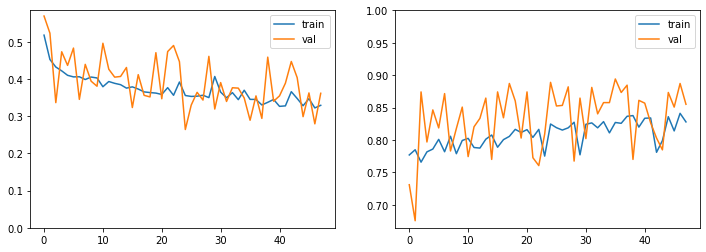

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6679 - accuracy: 0.5950 - precision: 0.7817 - recall: 0.5673 - f1: 0.6351 - specificity: 0.6394 - negative_predictive_value: 0.4116 - matthews_correlation_coefficient: 0.2055 - val_loss: 0.6671 - val_accuracy: 0.5924 - val_precision: 0.7939 - val_recall: 0.5105 - val_f1: 0.6164 - val_specificity: 0.7498 - val_negative_predictive_value: 0.4257 - val_matthews_correlation_coefficient: 0.2385

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23852, saving model to ../models/autoencoders_requirements/looking_away_2020_03_27-18_49_17.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6574 - accuracy: 0.6171 - precision: 0.7835 - recall: 0.6131 - f1: 0.6782 - specificity: 0.6197 - negative_predictive_value: 0.4235 - matthews_correlation_coefficient: 0.2187 - val_loss: 0.6805 - val_accuracy: 0.5672 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6118 - accuracy: 0.6694 - precision: 0.8271 - recall: 0.6665 - f1: 0.7311 - specificity: 0.6754 - negative_predictive_value: 0.4724 - matthews_correlation_coefficient: 0.3206 - val_loss: 0.5849 - val_accuracy: 0.6956 - val_precision: 0.7971 - val_recall: 0.6959 - val_f1: 0.7396 - val_specificity: 0.6658 - val_negative_predictive_value: 0.5160 - val_matthews_correlation_coefficient: 0.3355

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34573
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6053 - accuracy: 0.6748 - precision: 0.8338 - recall: 0.6679 - f1: 0.7333 - specificity: 0.6983 - negative_predictive_value: 0.4869 - matthews_correlation_coefficient: 0.3412 - val_loss: 0.5765 - val_accuracy: 0.6886 - val_precision: 0.7551 - val_recall: 0.7558 - val_f1: 0.7507 - val_specificity: 0.5138 - val_negative_predictive_value: 0.5095 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5786 - accuracy: 0.6928 - precision: 0.8362 - recall: 0.6963 - f1: 0.7519 - specificity: 0.6956 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.3646 - val_loss: 0.5954 - val_accuracy: 0.6886 - val_precision: 0.8233 - val_recall: 0.6488 - val_f1: 0.7223 - val_specificity: 0.7412 - val_negative_predictive_value: 0.5052 - val_matthews_correlation_coefficient: 0.3568

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37749
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5835 - accuracy: 0.6896 - precision: 0.8373 - recall: 0.6896 - f1: 0.7485 - specificity: 0.6999 - negative_predictive_value: 0.5060 - matthews_correlation_coefficient: 0.3644 - val_loss: 0.6108 - val_accuracy: 0.6878 - val_precision: 0.8335 - val_recall: 0.6346 - val_f1: 0.7175 - val_specificity: 0.7713 - val_negative_predictive_value: 0.5040 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5719 - accuracy: 0.6883 - precision: 0.8465 - recall: 0.6834 - f1: 0.7478 - specificity: 0.7158 - negative_predictive_value: 0.5085 - matthews_correlation_coefficient: 0.3750 - val_loss: 0.5500 - val_accuracy: 0.7155 - val_precision: 0.8044 - val_recall: 0.7191 - val_f1: 0.7552 - val_specificity: 0.6779 - val_negative_predictive_value: 0.5477 - val_matthews_correlation_coefficient: 0.3725

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.40213
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5570 - accuracy: 0.7076 - precision: 0.8484 - recall: 0.6977 - f1: 0.7590 - specificity: 0.7286 - negative_predictive_value: 0.5197 - matthews_correlation_coefficient: 0.3948 - val_loss: 0.5981 - val_accuracy: 0.6704 - val_precision: 0.8305 - val_recall: 0.6080 - val_f1: 0.6977 - val_specificity: 0.7782 - val_negative_predictive_value: 0.4906 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient improved from 0.41034 to 0.41506, saving model to ../models/autoencoders_requirements/looking_away_2020_03_27-18_49_17.h5
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5477 - accuracy: 0.7243 - precision: 0.8581 - recall: 0.7261 - f1: 0.7804 - specificity: 0.7157 - negative_predictive_value: 0.5428 - matthews_correlation_coefficient: 0.4191 - val_loss: 0.5627 - val_accuracy: 0.7077 - val_precision: 0.8310 - val_recall: 0.6663 - val_f1: 0.7356 - val_specificity: 0.7585 - val_negative_predictive_value: 0.5286 - val_matthews_correlation_coefficient: 0.3896

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.41506
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5473 - accuracy: 0.7171 - precision: 0.8486 - recall: 0.7127 - f1: 0.7676 - specificity: 0.7212 - negative_predictive_value: 0.5308 - matthews_correlation_coefficient: 0.4056 - val_loss: 0.5660 -


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.41506
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5296 - accuracy: 0.7321 - precision: 0.8520 - recall: 0.7309 - f1: 0.7814 - specificity: 0.7160 - negative_predictive_value: 0.5458 - matthews_correlation_coefficient: 0.4273 - val_loss: 0.7157 - val_accuracy: 0.5924 - val_precision: 0.8437 - val_recall: 0.4694 - val_f1: 0.5980 - val_specificity: 0.8411 - val_negative_predictive_value: 0.4326 - val_matthews_correlation_coefficient: 0.2912

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.41506
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5422 - accuracy: 0.7202 - precision: 0.8662 - recall: 0.7076 - f1: 0.7708 - specificity: 0.7504 - negative_predictive_value: 0.5420 - matthews_correlation_coefficient: 0.4327 - val_loss: 0.5662 - val_accuracy: 0.6973 - val_precision: 0.8353 - val_recall: 0.6465 - val_f1: 0.7245 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.41506
Epoch 00087: early stopping

   Final Accuracy:  72.94%
  Final Precision:  85.32%
     Final Recall:  73.56%
  Final F-measure:  79.00%
Final Specificity:  71.55%
        Final NPV:  54.62%
        Final MCC:  42.45%
[[254 101]
 [211 587]]
              precision    recall  f1-score   support

           0       0.55      0.72      0.62       355
           1       0.85      0.74      0.79       798

    accuracy                           0.73      1153
   macro avg       0.70      0.73      0.70      1153
weighted avg       0.76      0.73      0.74      1153



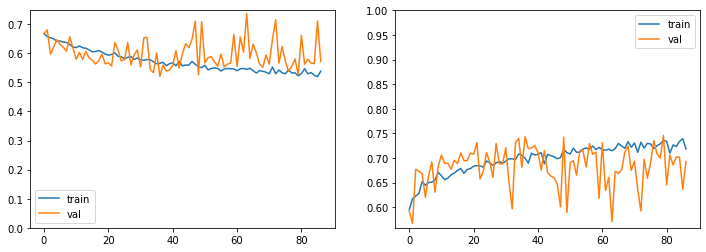

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6180 - accuracy: 0.6547 - precision: 0.7971 - recall: 0.6528 - f1: 0.6942 - specificity: 0.6437 - negative_predictive_value: 0.4974 - matthews_correlation_coefficient: 0.2950 - val_loss: 0.6565 - val_accuracy: 0.6435 - val_precision: 0.8108 - val_recall: 0.5723 - val_f1: 0.6666 - val_specificity: 0.7393 - val_negative_predictive_value: 0.4501 - val_matthews_correlation_coefficient: 0.3111

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31114, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_27-19_02_02.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5733 - accuracy: 0.7080 - precision: 0.8286 - recall: 0.7209 - f1: 0.7636 - specificity: 0.6813 - negative_predictive_value: 0.5370 - matthews_correlation_coefficient: 0.3841 - val_loss: 0.5681 - val_accuracy: 0.7051 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4677 - accuracy: 0.7866 - precision: 0.8616 - recall: 0.8178 - f1: 0.8346 - specificity: 0.7215 - negative_predictive_value: 0.6431 - matthews_correlation_coefficient: 0.5222 - val_loss: 0.5872 - val_accuracy: 0.7242 - val_precision: 0.8443 - val_recall: 0.6777 - val_f1: 0.7491 - val_specificity: 0.7622 - val_negative_predictive_value: 0.5321 - val_matthews_correlation_coefficient: 0.4328

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.51651
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4718 - accuracy: 0.7820 - precision: 0.8627 - recall: 0.8111 - f1: 0.8304 - specificity: 0.7250 - negative_predictive_value: 0.6438 - matthews_correlation_coefficient: 0.5207 - val_loss: 0.4417 - val_accuracy: 0.8005 - val_precision: 0.8313 - val_recall: 0.8232 - val_f1: 0.8253 - val_specificity: 0.6918 - val_negative_predictive_value: 0.6694 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.54663
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4497 - accuracy: 0.7905 - precision: 0.8721 - recall: 0.8203 - f1: 0.8394 - specificity: 0.7454 - negative_predictive_value: 0.6668 - matthews_correlation_coefficient: 0.5502 - val_loss: 0.5747 - val_accuracy: 0.7493 - val_precision: 0.8377 - val_recall: 0.7253 - val_f1: 0.7751 - val_specificity: 0.7403 - val_negative_predictive_value: 0.5689 - val_matthews_correlation_coefficient: 0.4610

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.54663
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4410 - accuracy: 0.7976 - precision: 0.8729 - recall: 0.8243 - f1: 0.8440 - specificity: 0.7502 - negative_predictive_value: 0.6718 - matthews_correlation_coefficient: 0.5579 - val_loss: 0.4499 - val_accuracy: 0.8014 - val_precision: 0.8495 - val_recall: 0.8008 - val_f1: 0.8228 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4439 - accuracy: 0.7967 - precision: 0.8793 - recall: 0.8178 - f1: 0.8430 - specificity: 0.7627 - negative_predictive_value: 0.6699 - matthews_correlation_coefficient: 0.5633 - val_loss: 0.4305 - val_accuracy: 0.7971 - val_precision: 0.8364 - val_recall: 0.8091 - val_f1: 0.8210 - val_specificity: 0.7093 - val_negative_predictive_value: 0.6539 - val_matthews_correlation_coefficient: 0.5301

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.55908
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4114 - accuracy: 0.8137 - precision: 0.8848 - recall: 0.8374 - f1: 0.8573 - specificity: 0.7705 - negative_predictive_value: 0.6895 - matthews_correlation_coefficient: 0.5896 - val_loss: 0.5350 - val_accuracy: 0.7285 - val_precision: 0.8612 - val_recall: 0.6627 - val_f1: 0.7471 - val_specificity: 0.8293 - val_negative_predictive_value: 0.5597 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.56606
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4195 - accuracy: 0.8104 - precision: 0.8841 - recall: 0.8325 - f1: 0.8530 - specificity: 0.7594 - negative_predictive_value: 0.6842 - matthews_correlation_coefficient: 0.5797 - val_loss: 0.4349 - val_accuracy: 0.8040 - val_precision: 0.8447 - val_recall: 0.8092 - val_f1: 0.8248 - val_specificity: 0.7516 - val_negative_predictive_value: 0.6872 - val_matthews_correlation_coefficient: 0.5450

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.56606
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4238 - accuracy: 0.8085 - precision: 0.8828 - recall: 0.8319 - f1: 0.8521 - specificity: 0.7761 - negative_predictive_value: 0.6852 - matthews_correlation_coefficient: 0.5857 - val_loss: 0.6215 - val_accuracy: 0.7424 - val_precision: 0.8491 - val_recall: 0.6999 - val_f1: 0.7650 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.57683
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3984 - accuracy: 0.8189 - precision: 0.8798 - recall: 0.8378 - f1: 0.8552 - specificity: 0.7688 - negative_predictive_value: 0.6985 - matthews_correlation_coefficient: 0.5926 - val_loss: 0.4681 - val_accuracy: 0.7936 - val_precision: 0.8539 - val_recall: 0.7824 - val_f1: 0.8150 - val_specificity: 0.7537 - val_negative_predictive_value: 0.6317 - val_matthews_correlation_coefficient: 0.5362

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.57683
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4099 - accuracy: 0.8074 - precision: 0.8920 - recall: 0.8186 - f1: 0.8491 - specificity: 0.7828 - negative_predictive_value: 0.6700 - matthews_correlation_coefficient: 0.5816 - val_loss: 0.4451 - val_accuracy: 0.7979 - val_precision: 0.8572 - val_recall: 0.7831 - val_f1: 0.8168 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3907 - accuracy: 0.8171 - precision: 0.8941 - recall: 0.8345 - f1: 0.8594 - specificity: 0.7850 - negative_predictive_value: 0.6856 - matthews_correlation_coefficient: 0.5973 - val_loss: 0.4384 - val_accuracy: 0.7936 - val_precision: 0.8424 - val_recall: 0.7971 - val_f1: 0.8171 - val_specificity: 0.7243 - val_negative_predictive_value: 0.6414 - val_matthews_correlation_coefficient: 0.5280

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.58264
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3860 - accuracy: 0.8215 - precision: 0.8967 - recall: 0.8359 - f1: 0.8612 - specificity: 0.7881 - negative_predictive_value: 0.6907 - matthews_correlation_coefficient: 0.6052 - val_loss: 0.3948 - val_accuracy: 0.8248 - val_precision: 0.8430 - val_recall: 0.8506 - val_f1: 0.8449 - val_specificity: 0.7126 - val_negative_predictive_value: 0.7121 - val_matthews_correlation_coefficie

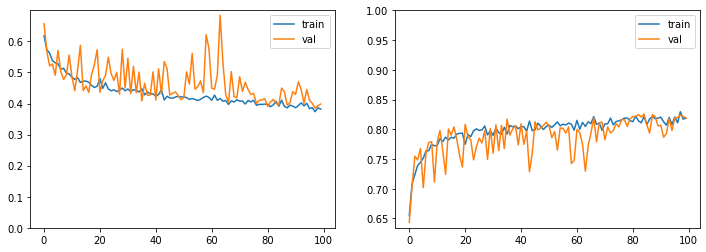

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5933 - accuracy: 0.7336 - precision: 0.9606 - recall: 0.7428 - f1: 0.8267 - specificity: 0.5709 - negative_predictive_value: 0.2093 - matthews_correlation_coefficient: 0.2234 - val_loss: 0.8410 - val_accuracy: 0.3625 - val_precision: 0.9657 - val_recall: 0.3026 - val_f1: 0.4537 - val_specificity: 0.9324 - val_negative_predictive_value: 0.1290 - val_matthews_correlation_coefficient: 0.1527

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.15273, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_27-19_16_37.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4908 - accuracy: 0.7599 - precision: 0.9730 - recall: 0.7626 - f1: 0.8432 - specificity: 0.7587 - negative_predictive_value: 0.2473 - matthews_correlation_coefficient: 0.3299 - val_loss: 0.4345 - val_accuracy: 0.8118 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.49290
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3843 - accuracy: 0.8399 - precision: 0.9833 - recall: 0.8425 - f1: 0.9045 - specificity: 0.7507 - negative_predictive_value: 0.3321 - matthews_correlation_coefficient: 0.4238 - val_loss: 0.3311 - val_accuracy: 0.8595 - val_precision: 0.9558 - val_recall: 0.8396 - val_f1: 0.8926 - val_specificity: 0.7162 - val_negative_predictive_value: 0.3375 - val_matthews_correlation_coefficient: 0.3973

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.49290
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3680 - accuracy: 0.8430 - precision: 0.9828 - recall: 0.8462 - f1: 0.9073 - specificity: 0.7497 - negative_predictive_value: 0.3071 - matthews_correlation_coefficient: 0.4056 - val_loss: 0.4145 - val_accuracy: 0.8213 - val_precision: 0.9617 - val_recall: 0.7929 - val_f1: 0.8677 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.49290
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3443 - accuracy: 0.8451 - precision: 0.9855 - recall: 0.8431 - f1: 0.9061 - specificity: 0.7737 - negative_predictive_value: 0.3269 - matthews_correlation_coefficient: 0.4333 - val_loss: 0.2548 - val_accuracy: 0.8925 - val_precision: 0.9571 - val_recall: 0.8735 - val_f1: 0.9122 - val_specificity: 0.7703 - val_negative_predictive_value: 0.4143 - val_matthews_correlation_coefficient: 0.4775

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.49290
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3315 - accuracy: 0.8577 - precision: 0.9851 - recall: 0.8605 - f1: 0.9163 - specificity: 0.7645 - negative_predictive_value: 0.3419 - matthews_correlation_coefficient: 0.4441 - val_loss: 0.3626 - val_accuracy: 0.8552 - val_precision: 0.9614 - val_recall: 0.8297 - val_f1: 0.8895 - val_spe

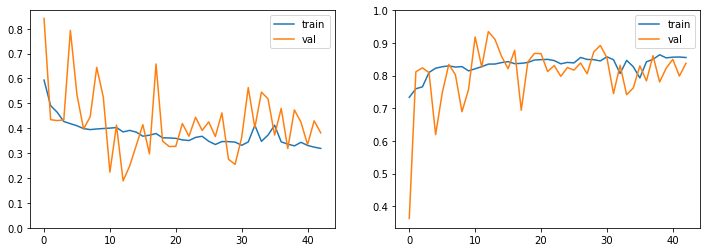

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5205 - accuracy: 0.7254 - precision: 0.9977 - recall: 0.7262 - f1: 0.8335 - specificity: 0.2805 - negative_predictive_value: 0.0382 - matthews_correlation_coefficient: 0.0832 - val_loss: 0.4140 - val_accuracy: 0.7190 - val_precision: 0.9714 - val_recall: 0.6971 - val_f1: 0.8093 - val_specificity: 0.2838 - val_negative_predictive_value: 0.0337 - val_matthews_correlation_coefficient: 0.0771

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.07713, saving model to ../models/autoencoders_requirements/washed_out_2020_03_27-19_23_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.6963 - precision: 0.9977 - recall: 0.6962 - f1: 0.8125 - specificity: 0.2736 - negative_predictive_value: 0.0306 - matthews_correlation_coefficient: 0.0680 - val_loss: 0.1727 - val_accuracy: 0.9037 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2552 - accuracy: 0.8544 - precision: 0.9985 - recall: 0.8546 - f1: 0.9169 - specificity: 0.2724 - negative_predictive_value: 0.0734 - matthews_correlation_coefficient: 0.1220 - val_loss: 0.2307 - val_accuracy: 0.8734 - val_precision: 0.9969 - val_recall: 0.8776 - val_f1: 0.9326 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0649 - val_matthews_correlation_coefficient: 0.1039

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.13619
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2414 - accuracy: 0.8709 - precision: 0.9993 - recall: 0.8706 - f1: 0.9260 - specificity: 0.3103 - negative_predictive_value: 0.1009 - matthews_correlation_coefficient: 0.1539 - val_loss: 0.1574 - val_accuracy: 0.9228 - val_precision: 0.9954 - val_recall: 0.9282 - val_f1: 0.9600 - val_specificity: 0.1757 - val_negative_predictive_value: 0.0829 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.13911
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1868 - accuracy: 0.9121 - precision: 0.9986 - recall: 0.9098 - f1: 0.9504 - specificity: 0.2966 - negative_predictive_value: 0.1080 - matthews_correlation_coefficient: 0.1650 - val_loss: 0.3455 - val_accuracy: 0.8187 - val_precision: 0.9717 - val_recall: 0.7957 - val_f1: 0.8732 - val_specificity: 0.2703 - val_negative_predictive_value: 0.0533 - val_matthews_correlation_coefficient: 0.1039

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.13911
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2000 - accuracy: 0.8896 - precision: 0.9991 - recall: 0.8900 - f1: 0.9399 - specificity: 0.2828 - negative_predictive_value: 0.1075 - matthews_correlation_coefficient: 0.1555 - val_loss: 0.1687 - val_accuracy: 0.9176 - val_precision: 0.9962 - val_recall: 0.9222 - val_f1: 0.9571 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2113 - accuracy: 0.8835 - precision: 0.9988 - recall: 0.8841 - f1: 0.9356 - specificity: 0.3034 - negative_predictive_value: 0.1201 - matthews_correlation_coefficient: 0.1696 - val_loss: 0.2218 - val_accuracy: 0.8959 - val_precision: 0.9969 - val_recall: 0.8999 - val_f1: 0.9452 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0797 - val_matthews_correlation_coefficient: 0.1219

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.16490
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1725 - accuracy: 0.9111 - precision: 0.9996 - recall: 0.9112 - f1: 0.9520 - specificity: 0.3241 - negative_predictive_value: 0.1416 - matthews_correlation_coefficient: 0.1979 - val_loss: 0.1074 - val_accuracy: 0.9480 - val_precision: 0.9964 - val_recall: 0.9521 - val_f1: 0.9735 - val_specificity: 0.2027 - val_negative_predictive_value: 0.1279 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1547 - accuracy: 0.9067 - precision: 0.9995 - recall: 0.9068 - f1: 0.9495 - specificity: 0.3034 - negative_predictive_value: 0.1376 - matthews_correlation_coefficient: 0.1877 - val_loss: 0.1483 - val_accuracy: 0.9306 - val_precision: 0.9981 - val_recall: 0.9333 - val_f1: 0.9642 - val_specificity: 0.2568 - val_negative_predictive_value: 0.1077 - val_matthews_correlation_coefficient: 0.1553

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.16490
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1390 - accuracy: 0.9330 - precision: 0.9996 - recall: 0.9330 - f1: 0.9644 - specificity: 0.2966 - negative_predictive_value: 0.1243 - matthews_correlation_coefficient: 0.1794 - val_loss: 0.2110 - val_accuracy: 0.9003 - val_precision: 0.9970 - val_recall: 0.9040 - val_f1: 0.9474 - val_specificity: 0.2297 - val_negative_predictive_value: 0.0768 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.19478
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1284 - accuracy: 0.9358 - precision: 0.9995 - recall: 0.9359 - f1: 0.9661 - specificity: 0.2931 - negative_predictive_value: 0.1306 - matthews_correlation_coefficient: 0.1825 - val_loss: 0.1333 - val_accuracy: 0.9376 - val_precision: 0.9981 - val_recall: 0.9401 - val_f1: 0.9679 - val_specificity: 0.2568 - val_negative_predictive_value: 0.1167 - val_matthews_correlation_coefficient: 0.1627

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.19478
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1483 - accuracy: 0.9295 - precision: 0.9991 - recall: 0.9300 - f1: 0.9627 - specificity: 0.2966 - negative_predictive_value: 0.1422 - matthews_correlation_coefficient: 0.1909 - val_loss: 0.1387 - val_accuracy: 0.9350 - val_precision: 0.9972 - val_recall: 0.9384 - val_f1: 0.9664 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.19478
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2201 - accuracy: 0.9030 - precision: 0.9989 - recall: 0.9039 - f1: 0.9467 - specificity: 0.2667 - negative_predictive_value: 0.1424 - matthews_correlation_coefficient: 0.1775 - val_loss: 0.1307 - val_accuracy: 0.9376 - val_precision: 0.9972 - val_recall: 0.9411 - val_f1: 0.9679 - val_specificity: 0.2297 - val_negative_predictive_value: 0.1261 - val_matthews_correlation_coefficient: 0.1578

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.19478
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1372 - accuracy: 0.9247 - precision: 0.9998 - recall: 0.9247 - f1: 0.9599 - specificity: 0.3103 - negative_predictive_value: 0.1415 - matthews_correlation_coefficient: 0.1961 - val_loss: 0.1286 - val_accuracy: 0.9410 - val_precision: 0.9972 - val_recall: 0.9444 - val_f1: 0.9698 - val_spe

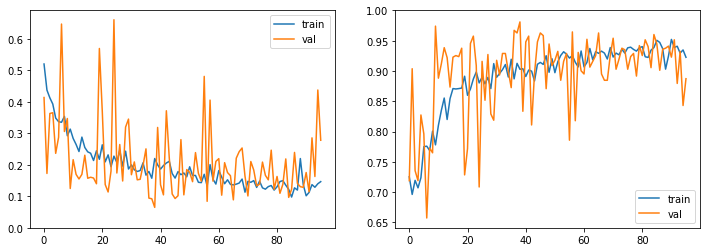

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6663 - accuracy: 0.5766 - precision: 0.9292 - recall: 0.5731 - f1: 0.6914 - specificity: 0.5446 - negative_predictive_value: 0.1015 - matthews_correlation_coefficient: 0.0937 - val_loss: 0.7513 - val_accuracy: 0.4666 - val_precision: 0.9394 - val_recall: 0.4324 - val_f1: 0.5877 - val_specificity: 0.6892 - val_negative_predictive_value: 0.0878 - val_matthews_correlation_coefficient: 0.1012

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.10120, saving model to ../models/autoencoders_requirements/pixelation_2020_03_27-19_37_11.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6339 - accuracy: 0.6076 - precision: 0.9710 - recall: 0.6010 - f1: 0.7333 - specificity: 0.6365 - negative_predictive_value: 0.1192 - matthews_correlation_coefficient: 0.1588 - val_loss: 0.5488 - val_accuracy: 0.6912 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5056 - accuracy: 0.6974 - precision: 0.9791 - recall: 0.6930 - f1: 0.8084 - specificity: 0.6984 - negative_predictive_value: 0.1578 - matthews_correlation_coefficient: 0.2353 - val_loss: 0.3391 - val_accuracy: 0.8387 - val_precision: 0.9618 - val_recall: 0.8661 - val_f1: 0.9095 - val_specificity: 0.4941 - val_negative_predictive_value: 0.2110 - val_matthews_correlation_coefficient: 0.2432

Epoch 00015: val_matthews_correlation_coefficient improved from 0.20053 to 0.24316, saving model to ../models/autoencoders_requirements/pixelation_2020_03_27-19_37_11.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5094 - accuracy: 0.7106 - precision: 0.9784 - recall: 0.7080 - f1: 0.8179 - specificity: 0.7006 - negative_predictive_value: 0.1618 - matthews_correlation_coefficient: 0.2401 - val_loss: 0.3124 - val_accuracy: 0.8526 - val_precision: 0.9621 - val_recall: 0.8802 - val_f1: 0.9177 - val_speci


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.26074
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4749 - accuracy: 0.7180 - precision: 0.9808 - recall: 0.7136 - f1: 0.8224 - specificity: 0.7206 - negative_predictive_value: 0.1709 - matthews_correlation_coefficient: 0.2585 - val_loss: 0.3993 - val_accuracy: 0.7598 - val_precision: 0.9692 - val_recall: 0.7739 - val_f1: 0.8576 - val_specificity: 0.5703 - val_negative_predictive_value: 0.1649 - val_matthews_correlation_coefficient: 0.2124

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.26074
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4778 - accuracy: 0.6918 - precision: 0.9840 - recall: 0.6804 - f1: 0.8009 - specificity: 0.7600 - negative_predictive_value: 0.1602 - matthews_correlation_coefficient: 0.2558 - val_loss: 0.4059 - val_accuracy: 0.7615 - val_precision: 0.9445 - val_recall: 0.7476 - val_f1: 0.8319 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.26317
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4727 - accuracy: 0.7356 - precision: 0.9805 - recall: 0.7301 - f1: 0.8341 - specificity: 0.7129 - negative_predictive_value: 0.1749 - matthews_correlation_coefficient: 0.2622 - val_loss: 0.3996 - val_accuracy: 0.7702 - val_precision: 0.9404 - val_recall: 0.7604 - val_f1: 0.8386 - val_specificity: 0.5577 - val_negative_predictive_value: 0.1654 - val_matthews_correlation_coefficient: 0.2107

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.26317
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4760 - accuracy: 0.7440 - precision: 0.9801 - recall: 0.7431 - f1: 0.8410 - specificity: 0.6754 - negative_predictive_value: 0.1883 - matthews_correlation_coefficient: 0.2666 - val_loss: 0.4144 - val_accuracy: 0.7398 - val_precision: 0.9382 - val_recall: 0.7295 - val_f1: 0.8181 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.26317
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4471 - accuracy: 0.7544 - precision: 0.9784 - recall: 0.7532 - f1: 0.8468 - specificity: 0.7264 - negative_predictive_value: 0.1901 - matthews_correlation_coefficient: 0.2864 - val_loss: 0.5488 - val_accuracy: 0.6990 - val_precision: 0.9442 - val_recall: 0.6808 - val_f1: 0.7880 - val_specificity: 0.6162 - val_negative_predictive_value: 0.1374 - val_matthews_correlation_coefficient: 0.1892

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.26317
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4826 - accuracy: 0.7267 - precision: 0.9813 - recall: 0.7228 - f1: 0.8276 - specificity: 0.6854 - negative_predictive_value: 0.1728 - matthews_correlation_coefficient: 0.2560 - val_loss: 0.3555 - val_accuracy: 0.8066 - val_precision: 0.9650 - val_recall: 0.8269 - val_f1: 0.8886 - val_spe

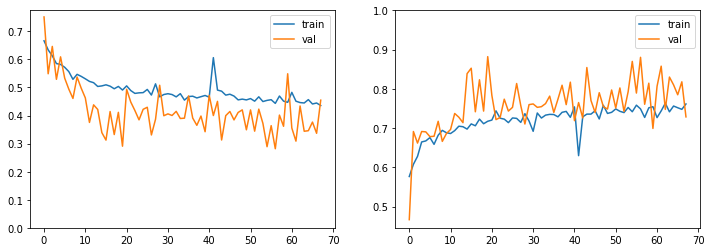

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5813 - accuracy: 0.6729 - precision: 0.9377 - recall: 0.6473 - f1: 0.7562 - specificity: 0.7911 - negative_predictive_value: 0.3329 - matthews_correlation_coefficient: 0.3402 - val_loss: 0.6580 - val_accuracy: 0.6600 - val_precision: 0.9285 - val_recall: 0.5999 - val_f1: 0.7219 - val_specificity: 0.8487 - val_negative_predictive_value: 0.3283 - val_matthews_correlation_coefficient: 0.3640

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.36402, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_27-19_47_11.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5542 - accuracy: 0.6729 - precision: 0.9488 - recall: 0.6349 - f1: 0.7571 - specificity: 0.8382 - negative_predictive_value: 0.3340 - matthews_correlation_coefficient: 0.3633 - val_loss: 0.5548 - val_accuracy: 0.6696 - val_preci


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.43595
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5098 - accuracy: 0.7228 - precision: 0.9441 - recall: 0.7040 - f1: 0.8020 - specificity: 0.8004 - negative_predictive_value: 0.3788 - matthews_correlation_coefficient: 0.4015 - val_loss: 0.5000 - val_accuracy: 0.7034 - val_precision: 0.9250 - val_recall: 0.6553 - val_f1: 0.7608 - val_specificity: 0.8313 - val_negative_predictive_value: 0.3653 - val_matthews_correlation_coefficient: 0.3997

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.43595
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5060 - accuracy: 0.7354 - precision: 0.9443 - recall: 0.7204 - f1: 0.8126 - specificity: 0.8019 - negative_predictive_value: 0.3935 - matthews_correlation_coefficient: 0.4171 - val_loss: 0.5341 - val_accuracy: 0.6947 - val_precision: 0.9345 - val_recall: 0.6383 - val_f1: 0.7515 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5031 - accuracy: 0.7219 - precision: 0.9412 - recall: 0.7100 - f1: 0.8015 - specificity: 0.7893 - negative_predictive_value: 0.3844 - matthews_correlation_coefficient: 0.3995 - val_loss: 0.4689 - val_accuracy: 0.7476 - val_precision: 0.9128 - val_recall: 0.7208 - val_f1: 0.8006 - val_specificity: 0.7771 - val_negative_predictive_value: 0.4030 - val_matthews_correlation_coefficient: 0.4197

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.44074
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4856 - accuracy: 0.7460 - precision: 0.9441 - recall: 0.7382 - f1: 0.8249 - specificity: 0.8052 - negative_predictive_value: 0.3976 - matthews_correlation_coefficient: 0.4258 - val_loss: 0.4796 - val_accuracy: 0.7355 - val_precision: 0.9189 - val_recall: 0.7010 - val_f1: 0.7891 - val_specificity: 0.7961 - val_negative_predictive_value: 0.3916 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.44694
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4836 - accuracy: 0.7416 - precision: 0.9509 - recall: 0.7269 - f1: 0.8191 - specificity: 0.8348 - negative_predictive_value: 0.4124 - matthews_correlation_coefficient: 0.4478 - val_loss: 0.5242 - val_accuracy: 0.7372 - val_precision: 0.9284 - val_recall: 0.6948 - val_f1: 0.7883 - val_specificity: 0.8330 - val_negative_predictive_value: 0.3999 - val_matthews_correlation_coefficient: 0.4398

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44694
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4742 - accuracy: 0.7501 - precision: 0.9427 - recall: 0.7404 - f1: 0.8248 - specificity: 0.7797 - negative_predictive_value: 0.4075 - matthews_correlation_coefficient: 0.4240 - val_loss: 0.4676 - val_accuracy: 0.7467 - val_precision: 0.9199 - val_recall: 0.7139 - val_f1: 0.7996 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48658
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4692 - accuracy: 0.7518 - precision: 0.9461 - recall: 0.7433 - f1: 0.8274 - specificity: 0.8090 - negative_predictive_value: 0.4208 - matthews_correlation_coefficient: 0.4437 - val_loss: 0.5287 - val_accuracy: 0.6956 - val_precision: 0.9329 - val_recall: 0.6387 - val_f1: 0.7511 - val_specificity: 0.8613 - val_negative_predictive_value: 0.3633 - val_matthews_correlation_coefficient: 0.4089

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.48658
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4627 - accuracy: 0.7633 - precision: 0.9471 - recall: 0.7554 - f1: 0.8372 - specificity: 0.8243 - negative_predictive_value: 0.4273 - matthews_correlation_coefficient: 0.4599 - val_loss: 0.6544 - val_accuracy: 0.6592 - val_precision: 0.9456 - val_recall: 0.5851 - val_f1: 0.7157 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.48658
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4543 - accuracy: 0.7605 - precision: 0.9556 - recall: 0.7429 - f1: 0.8300 - specificity: 0.8352 - negative_predictive_value: 0.4314 - matthews_correlation_coefficient: 0.4692 - val_loss: 0.4211 - val_accuracy: 0.7953 - val_precision: 0.9178 - val_recall: 0.7779 - val_f1: 0.8389 - val_specificity: 0.7654 - val_negative_predictive_value: 0.4594 - val_matthews_correlation_coefficient: 0.4760

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.48658
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4565 - accuracy: 0.7653 - precision: 0.9489 - recall: 0.7543 - f1: 0.8347 - specificity: 0.8091 - negative_predictive_value: 0.4341 - matthews_correlation_coefficient: 0.4614 - val_loss: 0.4595 - val_accuracy: 0.7823 - val_precision: 0.9424 - val_recall: 0.7901 - val_f1: 0.8544 - val_spe

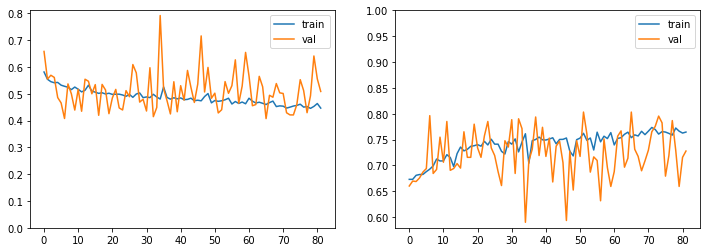

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6371 - accuracy: 0.5334 - precision: 0.9094 - recall: 0.4625 - f1: 0.5984 - specificity: 0.7935 - negative_predictive_value: 0.2719 - matthews_correlation_coefficient: 0.2183 - val_loss: 0.5831 - val_accuracy: 0.5542 - val_precision: 0.9167 - val_recall: 0.5018 - val_f1: 0.6384 - val_specificity: 0.7988 - val_negative_predictive_value: 0.2900 - val_matthews_correlation_coefficient: 0.2484

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24838, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_27-19_59_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6293 - accuracy: 0.5393 - precision: 0.9171 - recall: 0.4652 - f1: 0.6087 - specificity: 0.8278 - negative_predictive_value: 0.2872 - matthews_correlation_coefficient: 0.2429 - val_loss: 0.7371 - val_accuracy: 0.4666 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5785 - accuracy: 0.6575 - precision: 0.9091 - recall: 0.6253 - f1: 0.7315 - specificity: 0.7627 - negative_predictive_value: 0.3538 - matthews_correlation_coefficient: 0.3229 - val_loss: 0.5708 - val_accuracy: 0.6661 - val_precision: 0.8982 - val_recall: 0.6675 - val_f1: 0.7596 - val_specificity: 0.6941 - val_negative_predictive_value: 0.3472 - val_matthews_correlation_coefficient: 0.2965

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.30551
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5713 - accuracy: 0.6564 - precision: 0.9169 - recall: 0.6274 - f1: 0.7364 - specificity: 0.7728 - negative_predictive_value: 0.3622 - matthews_correlation_coefficient: 0.3318 - val_loss: 0.6826 - val_accuracy: 0.5733 - val_precision: 0.9329 - val_recall: 0.5112 - val_f1: 0.6527 - val_specificity: 0.8490 - val_negative_predictive_value: 0.3053 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.33608
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5397 - accuracy: 0.6965 - precision: 0.9190 - recall: 0.6798 - f1: 0.7763 - specificity: 0.7597 - negative_predictive_value: 0.3819 - matthews_correlation_coefficient: 0.3618 - val_loss: 0.6146 - val_accuracy: 0.6375 - val_precision: 0.9190 - val_recall: 0.6077 - val_f1: 0.7259 - val_specificity: 0.7775 - val_negative_predictive_value: 0.3328 - val_matthews_correlation_coefficient: 0.3102

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.33608
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5490 - accuracy: 0.6863 - precision: 0.9155 - recall: 0.6714 - f1: 0.7647 - specificity: 0.7626 - negative_predictive_value: 0.3893 - matthews_correlation_coefficient: 0.3606 - val_loss: 0.5437 - val_accuracy: 0.6730 - val_precision: 0.9065 - val_recall: 0.6669 - val_f1: 0.7648 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5348 - accuracy: 0.7132 - precision: 0.9207 - recall: 0.6936 - f1: 0.7820 - specificity: 0.7694 - negative_predictive_value: 0.4133 - matthews_correlation_coefficient: 0.3964 - val_loss: 0.6543 - val_accuracy: 0.6305 - val_precision: 0.9119 - val_recall: 0.6037 - val_f1: 0.7217 - val_specificity: 0.7574 - val_negative_predictive_value: 0.3258 - val_matthews_correlation_coefficient: 0.2919

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.34390
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5230 - accuracy: 0.7102 - precision: 0.9245 - recall: 0.6940 - f1: 0.7867 - specificity: 0.7733 - negative_predictive_value: 0.4035 - matthews_correlation_coefficient: 0.3883 - val_loss: 0.6032 - val_accuracy: 0.6574 - val_precision: 0.9125 - val_recall: 0.6383 - val_f1: 0.7471 - val_specificity: 0.7501 - val_negative_predictive_value: 0.3447 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5201 - accuracy: 0.7039 - precision: 0.9270 - recall: 0.6836 - f1: 0.7815 - specificity: 0.7891 - negative_predictive_value: 0.3993 - matthews_correlation_coefficient: 0.3894 - val_loss: 0.5326 - val_accuracy: 0.7034 - val_precision: 0.9138 - val_recall: 0.7015 - val_f1: 0.7904 - val_specificity: 0.7279 - val_negative_predictive_value: 0.3792 - val_matthews_correlation_coefficient: 0.3528

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.36146
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5121 - accuracy: 0.7258 - precision: 0.9228 - recall: 0.7158 - f1: 0.7985 - specificity: 0.7627 - negative_predictive_value: 0.4190 - matthews_correlation_coefficient: 0.4027 - val_loss: 0.6900 - val_accuracy: 0.6054 - val_precision: 0.9404 - val_recall: 0.5464 - val_f1: 0.6848 - val_specificity: 0.8552 - val_negative_predictive_value: 0.3233 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5035 - accuracy: 0.7247 - precision: 0.9259 - recall: 0.7088 - f1: 0.7955 - specificity: 0.7755 - negative_predictive_value: 0.4192 - matthews_correlation_coefficient: 0.4051 - val_loss: 0.5386 - val_accuracy: 0.7025 - val_precision: 0.8986 - val_recall: 0.7157 - val_f1: 0.7917 - val_specificity: 0.6826 - val_negative_predictive_value: 0.3805 - val_matthews_correlation_coefficient: 0.3313

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.36146
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5144 - accuracy: 0.7236 - precision: 0.9256 - recall: 0.7113 - f1: 0.7952 - specificity: 0.7657 - negative_predictive_value: 0.4226 - matthews_correlation_coefficient: 0.4038 - val_loss: 0.5694 - val_accuracy: 0.6791 - val_precision: 0.9299 - val_recall: 0.6539 - val_f1: 0.7621 - val_specificity: 0.8044 - val_negative_predictive_value: 0.3730 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.37063
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4936 - accuracy: 0.7208 - precision: 0.9299 - recall: 0.7022 - f1: 0.7941 - specificity: 0.7685 - negative_predictive_value: 0.4070 - matthews_correlation_coefficient: 0.3979 - val_loss: 0.5827 - val_accuracy: 0.6635 - val_precision: 0.9142 - val_recall: 0.6460 - val_f1: 0.7534 - val_specificity: 0.7516 - val_negative_predictive_value: 0.3472 - val_matthews_correlation_coefficient: 0.3207

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.37063
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4855 - accuracy: 0.7332 - precision: 0.9279 - recall: 0.7175 - f1: 0.8038 - specificity: 0.7818 - negative_predictive_value: 0.4243 - matthews_correlation_coefficient: 0.4161 - val_loss: 0.5887 - val_accuracy: 0.6557 - val_precision: 0.9124 - val_recall: 0.6347 - val_f1: 0.7440 - val_spe

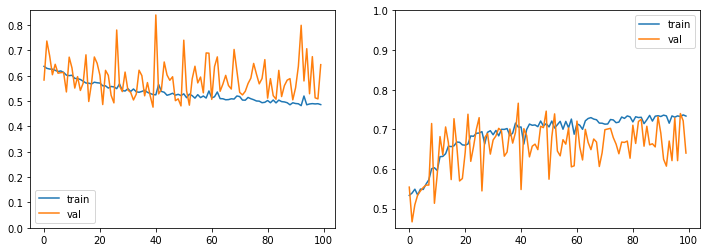

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4941 - accuracy: 0.7499 - precision: 0.8040 - recall: 0.7731 - f1: 0.7755 - specificity: 0.7326 - negative_predictive_value: 0.7019 - matthews_correlation_coefficient: 0.5046 - val_loss: 0.3975 - val_accuracy: 0.8144 - val_precision: 0.8761 - val_recall: 0.8062 - val_f1: 0.8341 - val_specificity: 0.8078 - val_negative_predictive_value: 0.7279 - val_matthews_correlation_coefficient: 0.6086

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.60858, saving model to ../models/autoencoders_requirements/varied_background_2020_03_27-20_13_59.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4185 - accuracy: 0.7905 - precision: 0.8464 - recall: 0.8008 - f1: 0.8140 - specificity: 0.7815 - negative_predictive_value: 0.7340 - matthews_correlation_coefficient: 0.5824 - val_loss: 0.3571 - val_accuracy: 0.8335 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.73944
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3397 - accuracy: 0.8267 - precision: 0.8662 - recall: 0.8510 - f1: 0.8507 - specificity: 0.8033 - negative_predictive_value: 0.7827 - matthews_correlation_coefficient: 0.6508 - val_loss: 0.3177 - val_accuracy: 0.8317 - val_precision: 0.8883 - val_recall: 0.7695 - val_f1: 0.8211 - val_specificity: 0.8635 - val_negative_predictive_value: 0.7291 - val_matthews_correlation_coefficient: 0.6517

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.73944
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3353 - accuracy: 0.8408 - precision: 0.8674 - recall: 0.8577 - f1: 0.8569 - specificity: 0.8224 - negative_predictive_value: 0.8046 - matthews_correlation_coefficient: 0.6751 - val_loss: 0.4242 - val_accuracy: 0.7598 - val_precision: 0.9205 - val_recall: 0.6131 - val_f1: 0.7303 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.73944
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3040 - accuracy: 0.8588 - precision: 0.8974 - recall: 0.8701 - f1: 0.8786 - specificity: 0.8443 - negative_predictive_value: 0.8117 - matthews_correlation_coefficient: 0.7110 - val_loss: 0.2828 - val_accuracy: 0.8777 - val_precision: 0.8476 - val_recall: 0.9753 - val_f1: 0.9053 - val_specificity: 0.7106 - val_negative_predictive_value: 0.9258 - val_matthews_correlation_coefficient: 0.7273

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.73944
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3033 - accuracy: 0.8562 - precision: 0.8790 - recall: 0.8738 - f1: 0.8715 - specificity: 0.8261 - negative_predictive_value: 0.8255 - matthews_correlation_coefficient: 0.7032 - val_loss: 0.2865 - val_accuracy: 0.8534 - val_precision: 0.9110 - val_recall: 0.8391 - val_f1: 0.8707 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2879 - accuracy: 0.8679 - precision: 0.8933 - recall: 0.8923 - f1: 0.8882 - specificity: 0.8439 - negative_predictive_value: 0.8365 - matthews_correlation_coefficient: 0.7325 - val_loss: 0.2485 - val_accuracy: 0.8985 - val_precision: 0.9051 - val_recall: 0.9300 - val_f1: 0.9152 - val_specificity: 0.8264 - val_negative_predictive_value: 0.8758 - val_matthews_correlation_coefficient: 0.7677

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.76947
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2818 - accuracy: 0.8698 - precision: 0.9064 - recall: 0.8734 - f1: 0.8861 - specificity: 0.8579 - negative_predictive_value: 0.8181 - matthews_correlation_coefficient: 0.7291 - val_loss: 0.2477 - val_accuracy: 0.9020 - val_precision: 0.8920 - val_recall: 0.9502 - val_f1: 0.9186 - val_specificity: 0.8054 - val_negative_predictive_value: 0.9053 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.78763
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2760 - accuracy: 0.8768 - precision: 0.9016 - recall: 0.8834 - f1: 0.8885 - specificity: 0.8633 - negative_predictive_value: 0.8320 - matthews_correlation_coefficient: 0.7466 - val_loss: 0.2428 - val_accuracy: 0.9003 - val_precision: 0.8944 - val_recall: 0.9467 - val_f1: 0.9177 - val_specificity: 0.8073 - val_negative_predictive_value: 0.8983 - val_matthews_correlation_coefficient: 0.7722

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.78763
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2802 - accuracy: 0.8690 - precision: 0.9015 - recall: 0.8793 - f1: 0.8848 - specificity: 0.8541 - negative_predictive_value: 0.8264 - matthews_correlation_coefficient: 0.7319 - val_loss: 0.2613 - val_accuracy: 0.8630 - val_precision: 0.9126 - val_recall: 0.8561 - val_f1: 0.8799 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.79202
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2567 - accuracy: 0.8852 - precision: 0.9030 - recall: 0.9038 - f1: 0.8988 - specificity: 0.8584 - negative_predictive_value: 0.8555 - matthews_correlation_coefficient: 0.7616 - val_loss: 0.2591 - val_accuracy: 0.8794 - val_precision: 0.9244 - val_recall: 0.8720 - val_f1: 0.8947 - val_specificity: 0.8661 - val_negative_predictive_value: 0.8029 - val_matthews_correlation_coefficient: 0.7324

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.79202
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2701 - accuracy: 0.8740 - precision: 0.8992 - recall: 0.8797 - f1: 0.8839 - specificity: 0.8644 - negative_predictive_value: 0.8421 - matthews_correlation_coefficient: 0.7419 - val_loss: 0.2371 - val_accuracy: 0.9046 - val_precision: 0.9006 - val_recall: 0.9453 - val_f1: 0.9208 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.79542
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2560 - accuracy: 0.8866 - precision: 0.9122 - recall: 0.9022 - f1: 0.9028 - specificity: 0.8724 - negative_predictive_value: 0.8566 - matthews_correlation_coefficient: 0.7709 - val_loss: 0.2764 - val_accuracy: 0.8803 - val_precision: 0.8570 - val_recall: 0.9638 - val_f1: 0.9055 - val_specificity: 0.7338 - val_negative_predictive_value: 0.9107 - val_matthews_correlation_coefficient: 0.7307

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.79542
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2517 - accuracy: 0.8896 - precision: 0.9145 - recall: 0.9027 - f1: 0.9051 - specificity: 0.8726 - negative_predictive_value: 0.8518 - matthews_correlation_coefficient: 0.7702 - val_loss: 0.2408 - val_accuracy: 0.8933 - val_precision: 0.8625 - val_recall: 0.9825 - val_f1: 0.9169 - val_spe

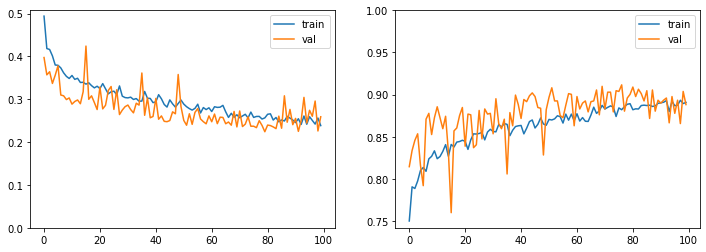

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5830 - accuracy: 0.7048 - precision: 0.9148 - recall: 0.6845 - f1: 0.7752 - specificity: 0.7702 - negative_predictive_value: 0.4189 - matthews_correlation_coefficient: 0.3899 - val_loss: 0.6499 - val_accuracy: 0.6886 - val_precision: 0.9252 - val_recall: 0.6547 - val_f1: 0.7625 - val_specificity: 0.8059 - val_negative_predictive_value: 0.4077 - val_matthews_correlation_coefficient: 0.3902

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39020, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_27-20_28_39.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5685 - accuracy: 0.7076 - precision: 0.9178 - recall: 0.6780 - f1: 0.7760 - specificity: 0.8025 - negative_predictive_value: 0.4285 - matthews_correlation_coefficient: 0.4058 - val_loss: 0.5655 - val_accuracy: 0.6964 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5554 - accuracy: 0.7080 - precision: 0.9280 - recall: 0.6712 - f1: 0.7752 - specificity: 0.8286 - negative_predictive_value: 0.4321 - matthews_correlation_coefficient: 0.4229 - val_loss: 0.5764 - val_accuracy: 0.6973 - val_precision: 0.9193 - val_recall: 0.6726 - val_f1: 0.7726 - val_specificity: 0.7844 - val_negative_predictive_value: 0.4151 - val_matthews_correlation_coefficient: 0.3895

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39945
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5499 - accuracy: 0.7076 - precision: 0.9229 - recall: 0.6793 - f1: 0.7783 - specificity: 0.8104 - negative_predictive_value: 0.4333 - matthews_correlation_coefficient: 0.4154 - val_loss: 0.5508 - val_accuracy: 0.7008 - val_precision: 0.9185 - val_recall: 0.6782 - val_f1: 0.7757 - val_specificity: 0.7838 - val_negative_predictive_value: 0.4201 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40023
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5428 - accuracy: 0.7095 - precision: 0.9176 - recall: 0.6722 - f1: 0.7724 - specificity: 0.8162 - negative_predictive_value: 0.4375 - matthews_correlation_coefficient: 0.4151 - val_loss: 0.5551 - val_accuracy: 0.6973 - val_precision: 0.9271 - val_recall: 0.6673 - val_f1: 0.7706 - val_specificity: 0.8057 - val_negative_predictive_value: 0.4183 - val_matthews_correlation_coefficient: 0.4027

Epoch 00030: val_matthews_correlation_coefficient improved from 0.40023 to 0.40274, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_27-20_28_39.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5503 - accuracy: 0.7056 - precision: 0.9272 - recall: 0.6695 - f1: 0.7732 - specificity: 0.8180 - negative_predictive_value: 0.4294 - matthews_correlation_coefficient: 0.4158 - val_loss: 0.5236


Epoch 00044: val_matthews_correlation_coefficient improved from 0.40274 to 0.40745, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_27-20_28_39.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5395 - accuracy: 0.7130 - precision: 0.9221 - recall: 0.6873 - f1: 0.7841 - specificity: 0.7990 - negative_predictive_value: 0.4326 - matthews_correlation_coefficient: 0.4128 - val_loss: 0.5070 - val_accuracy: 0.7173 - val_precision: 0.8893 - val_recall: 0.7302 - val_f1: 0.7985 - val_specificity: 0.6828 - val_negative_predictive_value: 0.4285 - val_matthews_correlation_coefficient: 0.3608

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.40745
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5388 - accuracy: 0.7152 - precision: 0.9262 - recall: 0.6830 - f1: 0.7825 - specificity: 0.8212 - negative_predictive_value: 0.4363 - matthews_correlation_coefficient: 0.4260 - val_loss: 0.5461


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40745
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5366 - accuracy: 0.7193 - precision: 0.9203 - recall: 0.6937 - f1: 0.7865 - specificity: 0.8095 - negative_predictive_value: 0.4413 - matthews_correlation_coefficient: 0.4259 - val_loss: 0.5877 - val_accuracy: 0.6956 - val_precision: 0.9261 - val_recall: 0.6651 - val_f1: 0.7694 - val_specificity: 0.8028 - val_negative_predictive_value: 0.4147 - val_matthews_correlation_coefficient: 0.3979

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.40745
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5367 - accuracy: 0.7089 - precision: 0.9270 - recall: 0.6772 - f1: 0.7788 - specificity: 0.8295 - negative_predictive_value: 0.4380 - matthews_correlation_coefficient: 0.4270 - val_loss: 0.6107 - val_accuracy: 0.6990 - val_precision: 0.9257 - val_recall: 0.6696 - val_f1: 0.7727 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40745
Epoch 00074: early stopping

   Final Accuracy:  69.64%
  Final Precision:  92.94%
     Final Recall:  65.42%
  Final F-measure:  76.79%
Final Specificity:  83.58%
        Final NPV:  42.26%
        Final MCC:  41.53%
[[224  44]
 [306 579]]
              precision    recall  f1-score   support

           0       0.42      0.84      0.56       268
           1       0.93      0.65      0.77       885

    accuracy                           0.70      1153
   macro avg       0.68      0.75      0.66      1153
weighted avg       0.81      0.70      0.72      1153



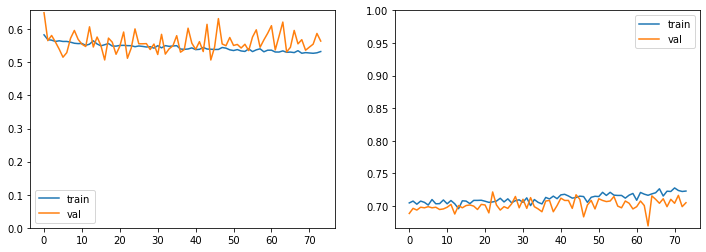

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6002 - accuracy: 0.6740 - precision: 0.7438 - recall: 0.6415 - f1: 0.6580 - specificity: 0.7113 - negative_predictive_value: 0.6476 - matthews_correlation_coefficient: 0.3701 - val_loss: 0.5271 - val_accuracy: 0.7537 - val_precision: 0.6986 - val_recall: 0.8799 - val_f1: 0.7727 - val_specificity: 0.5614 - val_negative_predictive_value: 0.7966 - val_matthews_correlation_coefficient: 0.4928

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.49284, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_27-20_39_35.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5459 - accuracy: 0.7271 - precision: 0.7542 - recall: 0.7598 - f1: 0.7445 - specificity: 0.6978 - negative_predictive_value: 0.7226 - matthews_correlation_coefficient: 0.4665 - val_loss: 0.4969 - val_accuracy: 0.7476 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4407 - accuracy: 0.7807 - precision: 0.7894 - recall: 0.8077 - f1: 0.7925 - specificity: 0.7446 - negative_predictive_value: 0.7649 - matthews_correlation_coefficient: 0.5598 - val_loss: 0.4685 - val_accuracy: 0.7710 - val_precision: 0.7120 - val_recall: 0.8853 - val_f1: 0.7843 - val_specificity: 0.5856 - val_negative_predictive_value: 0.8101 - val_matthews_correlation_coefficient: 0.5214

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.56664
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4641 - accuracy: 0.7764 - precision: 0.8017 - recall: 0.7997 - f1: 0.7908 - specificity: 0.7565 - negative_predictive_value: 0.7696 - matthews_correlation_coefficient: 0.5630 - val_loss: 0.4288 - val_accuracy: 0.7832 - val_precision: 0.7244 - val_recall: 0.8852 - val_f1: 0.7922 - val_specificity: 0.6163 - val_negative_predictive_value: 0.8205 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4303 - accuracy: 0.7824 - precision: 0.8055 - recall: 0.7883 - f1: 0.7884 - specificity: 0.7787 - negative_predictive_value: 0.7610 - matthews_correlation_coefficient: 0.5681 - val_loss: 0.4219 - val_accuracy: 0.7944 - val_precision: 0.8189 - val_recall: 0.7468 - val_f1: 0.7739 - val_specificity: 0.8312 - val_negative_predictive_value: 0.7469 - val_matthews_correlation_coefficient: 0.5709

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.57711
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4144 - accuracy: 0.7900 - precision: 0.8118 - recall: 0.8030 - f1: 0.8017 - specificity: 0.7692 - negative_predictive_value: 0.7641 - matthews_correlation_coefficient: 0.5755 - val_loss: 0.4101 - val_accuracy: 0.8005 - val_precision: 0.7804 - val_recall: 0.8162 - val_f1: 0.7921 - val_specificity: 0.7621 - val_negative_predictive_value: 0.7944 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.58744
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4089 - accuracy: 0.7957 - precision: 0.8312 - recall: 0.7997 - f1: 0.8061 - specificity: 0.7977 - negative_predictive_value: 0.7772 - matthews_correlation_coefficient: 0.6024 - val_loss: 0.4149 - val_accuracy: 0.8014 - val_precision: 0.7627 - val_recall: 0.8530 - val_f1: 0.8012 - val_specificity: 0.6951 - val_negative_predictive_value: 0.7882 - val_matthews_correlation_coefficient: 0.5759

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.58744
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3979 - accuracy: 0.8028 - precision: 0.8204 - recall: 0.8085 - f1: 0.8087 - specificity: 0.7899 - negative_predictive_value: 0.7799 - matthews_correlation_coefficient: 0.5992 - val_loss: 0.3985 - val_accuracy: 0.8005 - val_precision: 0.7794 - val_recall: 0.8196 - val_f1: 0.7934 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3906 - accuracy: 0.8061 - precision: 0.8346 - recall: 0.8108 - f1: 0.8139 - specificity: 0.7970 - negative_predictive_value: 0.7820 - matthews_correlation_coefficient: 0.6132 - val_loss: 0.3938 - val_accuracy: 0.8109 - val_precision: 0.8076 - val_recall: 0.7894 - val_f1: 0.7932 - val_specificity: 0.8123 - val_negative_predictive_value: 0.7864 - val_matthews_correlation_coefficient: 0.5971

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.60455
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3909 - accuracy: 0.8095 - precision: 0.8313 - recall: 0.8208 - f1: 0.8190 - specificity: 0.7944 - negative_predictive_value: 0.7870 - matthews_correlation_coefficient: 0.6181 - val_loss: 0.4094 - val_accuracy: 0.8075 - val_precision: 0.7769 - val_recall: 0.8420 - val_f1: 0.8033 - val_specificity: 0.7427 - val_negative_predictive_value: 0.8137 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.61424
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3858 - accuracy: 0.8171 - precision: 0.8366 - recall: 0.8193 - f1: 0.8209 - specificity: 0.8087 - negative_predictive_value: 0.7915 - matthews_correlation_coefficient: 0.6277 - val_loss: 0.4094 - val_accuracy: 0.7997 - val_precision: 0.8186 - val_recall: 0.7605 - val_f1: 0.7828 - val_specificity: 0.8054 - val_negative_predictive_value: 0.7317 - val_matthews_correlation_coefficient: 0.5844

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.61424
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3823 - accuracy: 0.8152 - precision: 0.8405 - recall: 0.8261 - f1: 0.8265 - specificity: 0.8101 - negative_predictive_value: 0.7979 - matthews_correlation_coefficient: 0.6369 - val_loss: 0.4184 - val_accuracy: 0.8057 - val_precision: 0.8106 - val_recall: 0.7892 - val_f1: 0.7933 - val_spe


Epoch 00087: val_matthews_correlation_coefficient improved from 0.61424 to 0.61916, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_27-20_39_35.h5
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3592 - accuracy: 0.8336 - precision: 0.8547 - recall: 0.8397 - f1: 0.8421 - specificity: 0.8237 - negative_predictive_value: 0.8096 - matthews_correlation_coefficient: 0.6635 - val_loss: 0.4225 - val_accuracy: 0.7962 - val_precision: 0.7507 - val_recall: 0.8621 - val_f1: 0.7977 - val_specificity: 0.6737 - val_negative_predictive_value: 0.8028 - val_matthews_correlation_coefficient: 0.5704

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.61916
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3697 - accuracy: 0.8226 - precision: 0.8479 - recall: 0.8214 - f1: 0.8290 - specificity: 0.8142 - negative_predictive_value: 0.7945 - matthews_correlation_coefficient: 0.6404 - val_lo

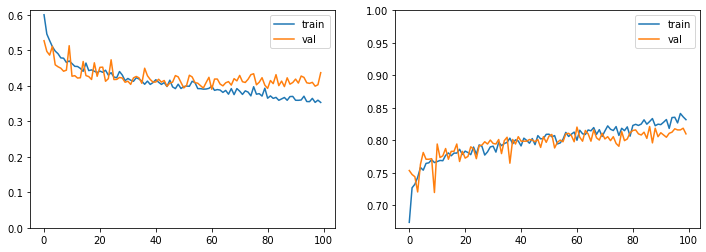

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6376 - accuracy: 0.5249 - precision: 0.8937 - recall: 0.4503 - f1: 0.5880 - specificity: 0.7973 - negative_predictive_value: 0.2837 - matthews_correlation_coefficient: 0.2144 - val_loss: 0.6779 - val_accuracy: 0.4701 - val_precision: 0.9492 - val_recall: 0.3642 - val_f1: 0.5153 - val_specificity: 0.9042 - val_negative_predictive_value: 0.2715 - val_matthews_correlation_coefficient: 0.2417

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24172, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_27-20_54_25.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6247 - accuracy: 0.5334 - precision: 0.9139 - recall: 0.4547 - f1: 0.5925 - specificity: 0.8145 - negative_predictive_value: 0.2912 - matthews_correlation_coefficient: 0.2348 - val_loss: 0.6665 - val_accuracy: 0.4892 - val_precision: 0


Epoch 00014: val_matthews_correlation_coefficient improved from 0.36454 to 0.39547, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_27-20_54_25.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5790 - accuracy: 0.6252 - precision: 0.9204 - recall: 0.5777 - f1: 0.7024 - specificity: 0.7969 - negative_predictive_value: 0.3400 - matthews_correlation_coefficient: 0.3108 - val_loss: 0.5972 - val_accuracy: 0.5872 - val_precision: 0.9518 - val_recall: 0.5131 - val_f1: 0.6586 - val_specificity: 0.8860 - val_negative_predictive_value: 0.3238 - val_matthews_correlation_coefficient: 0.3299

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39547
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5670 - accuracy: 0.6484 - precision: 0.9214 - recall: 0.6073 - f1: 0.7240 - specificity: 0.8010 - negative_predictive_value: 0.3587 - matthews_correlation_coefficient: 0.3362 - val_loss: 0.5727 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5462 - accuracy: 0.6870 - precision: 0.9158 - recall: 0.6658 - f1: 0.7612 - specificity: 0.7611 - negative_predictive_value: 0.3975 - matthews_correlation_coefficient: 0.3653 - val_loss: 0.6215 - val_accuracy: 0.6002 - val_precision: 0.9451 - val_recall: 0.5333 - val_f1: 0.6752 - val_specificity: 0.8754 - val_negative_predictive_value: 0.3293 - val_matthews_correlation_coefficient: 0.3333

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39649
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5379 - accuracy: 0.6926 - precision: 0.9182 - recall: 0.6609 - f1: 0.7599 - specificity: 0.7849 - negative_predictive_value: 0.4090 - matthews_correlation_coefficient: 0.3805 - val_loss: 0.5447 - val_accuracy: 0.6860 - val_precision: 0.9415 - val_recall: 0.6495 - val_f1: 0.7640 - val_specificity: 0.8304 - val_negative_predictive_value: 0.3845 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43243
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5182 - accuracy: 0.7148 - precision: 0.9270 - recall: 0.6970 - f1: 0.7883 - specificity: 0.8041 - negative_predictive_value: 0.4271 - matthews_correlation_coefficient: 0.4174 - val_loss: 0.5084 - val_accuracy: 0.7441 - val_precision: 0.9177 - val_recall: 0.7529 - val_f1: 0.8233 - val_specificity: 0.7161 - val_negative_predictive_value: 0.4297 - val_matthews_correlation_coefficient: 0.4019

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43243
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5103 - accuracy: 0.7193 - precision: 0.9307 - recall: 0.6946 - f1: 0.7891 - specificity: 0.7967 - negative_predictive_value: 0.4225 - matthews_correlation_coefficient: 0.4150 - val_loss: 0.5044 - val_accuracy: 0.7259 - val_precision: 0.9159 - val_recall: 0.7289 - val_f1: 0.8083 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43243
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4962 - accuracy: 0.7302 - precision: 0.9169 - recall: 0.7131 - f1: 0.7965 - specificity: 0.7821 - negative_predictive_value: 0.4341 - matthews_correlation_coefficient: 0.4153 - val_loss: 0.4583 - val_accuracy: 0.7641 - val_precision: 0.8943 - val_recall: 0.8044 - val_f1: 0.8442 - val_specificity: 0.6088 - val_negative_predictive_value: 0.4523 - val_matthews_correlation_coefficient: 0.3765

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43243
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4986 - accuracy: 0.7284 - precision: 0.9253 - recall: 0.7162 - f1: 0.7987 - specificity: 0.7869 - negative_predictive_value: 0.4461 - matthews_correlation_coefficient: 0.4283 - val_loss: 0.6620 - val_accuracy: 0.6297 - val_precision: 0.9536 - val_recall: 0.5694 - val_f1: 0.7067 - val_spe

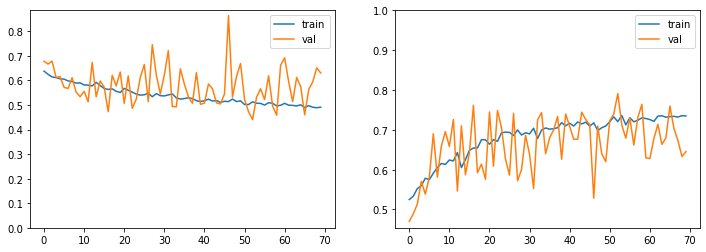

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4542 - accuracy: 0.7668 - precision: 0.8631 - recall: 0.7444 - f1: 0.7922 - specificity: 0.8186 - negative_predictive_value: 0.6726 - matthews_correlation_coefficient: 0.5484 - val_loss: 0.4261 - val_accuracy: 0.7780 - val_precision: 0.8804 - val_recall: 0.6914 - val_f1: 0.7705 - val_specificity: 0.8889 - val_negative_predictive_value: 0.6677 - val_matthews_correlation_coefficient: 0.5631

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.56309, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_27-21_04_53.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3925 - accuracy: 0.8069 - precision: 0.8924 - recall: 0.7683 - f1: 0.8211 - specificity: 0.8612 - negative_predictive_value: 0.7034 - matthews_correlation_coefficient: 0.6119 - val_loss: 0.4476 - val_accuracy: 0.7684 - val_pr


Epoch 00014: val_matthews_correlation_coefficient improved from 0.66315 to 0.66640, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_27-21_04_53.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3406 - accuracy: 0.8456 - precision: 0.9171 - recall: 0.8123 - f1: 0.8582 - specificity: 0.8909 - negative_predictive_value: 0.7489 - matthews_correlation_coefficient: 0.6838 - val_loss: 0.3612 - val_accuracy: 0.8248 - val_precision: 0.9171 - val_recall: 0.7401 - val_f1: 0.8156 - val_specificity: 0.9224 - val_negative_predictive_value: 0.7156 - val_matthews_correlation_coefficient: 0.6465

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.66640
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3399 - accuracy: 0.8445 - precision: 0.9180 - recall: 0.8135 - f1: 0.8594 - specificity: 0.8910 - negative_predictive_value: 0.7490 - matthews_correlation_coefficient: 0.6869 - val_loss: 0


Epoch 00028: val_matthews_correlation_coefficient improved from 0.70526 to 0.72337, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_27-21_04_53.h5
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3197 - accuracy: 0.8542 - precision: 0.9221 - recall: 0.8359 - f1: 0.8720 - specificity: 0.8824 - negative_predictive_value: 0.7724 - matthews_correlation_coefficient: 0.7074 - val_loss: 0.3184 - val_accuracy: 0.8474 - val_precision: 0.9142 - val_recall: 0.7835 - val_f1: 0.8399 - val_specificity: 0.9106 - val_negative_predictive_value: 0.7517 - val_matthews_correlation_coefficient: 0.6791

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.72337
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3074 - accuracy: 0.8601 - precision: 0.9192 - recall: 0.8463 - f1: 0.8778 - specificity: 0.8784 - negative_predictive_value: 0.7782 - matthews_correlation_coefficient: 0.7122 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3092 - accuracy: 0.8605 - precision: 0.9197 - recall: 0.8492 - f1: 0.8791 - specificity: 0.8838 - negative_predictive_value: 0.7925 - matthews_correlation_coefficient: 0.7219 - val_loss: 0.2789 - val_accuracy: 0.8890 - val_precision: 0.9020 - val_recall: 0.8669 - val_f1: 0.8821 - val_specificity: 0.8853 - val_negative_predictive_value: 0.8397 - val_matthews_correlation_coefficient: 0.7465

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.75496
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2840 - accuracy: 0.8779 - precision: 0.9256 - recall: 0.8737 - f1: 0.8960 - specificity: 0.8862 - negative_predictive_value: 0.8141 - matthews_correlation_coefficient: 0.7491 - val_loss: 0.2731 - val_accuracy: 0.8916 - val_precision: 0.9061 - val_recall: 0.8670 - val_f1: 0.8844 - val_specificity: 0.8915 - val_negative_predictive_value: 0.8379 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2802 - accuracy: 0.8829 - precision: 0.9274 - recall: 0.8795 - f1: 0.8999 - specificity: 0.8899 - negative_predictive_value: 0.8192 - matthews_correlation_coefficient: 0.7573 - val_loss: 0.2839 - val_accuracy: 0.8803 - val_precision: 0.9171 - val_recall: 0.8364 - val_f1: 0.8727 - val_specificity: 0.9113 - val_negative_predictive_value: 0.8052 - val_matthews_correlation_coefficient: 0.7346

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.75496
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2835 - accuracy: 0.8768 - precision: 0.9251 - recall: 0.8719 - f1: 0.8943 - specificity: 0.8844 - negative_predictive_value: 0.8083 - matthews_correlation_coefficient: 0.7444 - val_loss: 0.2793 - val_accuracy: 0.8864 - val_precision: 0.9105 - val_recall: 0.8521 - val_f1: 0.8785 - val_specificity: 0.9014 - val_negative_predictive_value: 0.8233 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2627 - accuracy: 0.8863 - precision: 0.9273 - recall: 0.8846 - f1: 0.9029 - specificity: 0.8862 - negative_predictive_value: 0.8258 - matthews_correlation_coefficient: 0.7614 - val_loss: 0.2645 - val_accuracy: 0.8899 - val_precision: 0.9146 - val_recall: 0.8557 - val_f1: 0.8819 - val_specificity: 0.9045 - val_negative_predictive_value: 0.8272 - val_matthews_correlation_coefficient: 0.7506

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.77806
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2646 - accuracy: 0.8870 - precision: 0.9271 - recall: 0.8863 - f1: 0.9034 - specificity: 0.8865 - negative_predictive_value: 0.8241 - matthews_correlation_coefficient: 0.7615 - val_loss: 0.2688 - val_accuracy: 0.8899 - val_precision: 0.8730 - val_recall: 0.9063 - val_f1: 0.8872 - val_specificity: 0.8244 - val_negative_predictive_value: 0.8783 - val_matthews_correlation_coefficie


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.77895
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2516 - accuracy: 0.8972 - precision: 0.9290 - recall: 0.8979 - f1: 0.9105 - specificity: 0.8932 - negative_predictive_value: 0.8381 - matthews_correlation_coefficient: 0.7802 - val_loss: 0.2540 - val_accuracy: 0.8977 - val_precision: 0.9183 - val_recall: 0.8633 - val_f1: 0.8881 - val_specificity: 0.9157 - val_negative_predictive_value: 0.8384 - val_matthews_correlation_coefficient: 0.7672

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.77895
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2563 - accuracy: 0.8902 - precision: 0.9296 - recall: 0.8901 - f1: 0.9063 - specificity: 0.8972 - negative_predictive_value: 0.8368 - matthews_correlation_coefficient: 0.7761 - val_loss: 0.2533 - val_accuracy: 0.8968 - val_precision: 0.8841 - val_recall: 0.9055 - val_f1: 0.8923 - val_spe

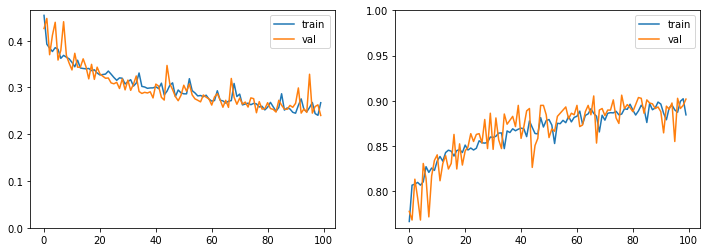

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6023 - accuracy: 0.6731 - precision: 0.7652 - recall: 0.6853 - f1: 0.7043 - specificity: 0.6645 - negative_predictive_value: 0.6072 - matthews_correlation_coefficient: 0.3584 - val_loss: 0.5582 - val_accuracy: 0.6947 - val_precision: 0.7794 - val_recall: 0.6433 - val_f1: 0.6988 - val_specificity: 0.7293 - val_negative_predictive_value: 0.5782 - val_matthews_correlation_coefficient: 0.3916

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39162, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_27-21_19_41.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5634 - accuracy: 0.7100 - precision: 0.7956 - recall: 0.7195 - f1: 0.7438 - specificity: 0.7083 - negative_predictive_value: 0.6330 - matthews_correlation_coefficient: 0.4269 - val_loss: 0.5380 - val_accuracy: 0.7173 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5059 - accuracy: 0.7560 - precision: 0.8182 - recall: 0.7677 - f1: 0.7851 - specificity: 0.7256 - negative_predictive_value: 0.6795 - matthews_correlation_coefficient: 0.4965 - val_loss: 0.4668 - val_accuracy: 0.7832 - val_precision: 0.7768 - val_recall: 0.8309 - val_f1: 0.8005 - val_specificity: 0.6510 - val_negative_predictive_value: 0.7323 - val_matthews_correlation_coefficient: 0.5217

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.53893
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5020 - accuracy: 0.7653 - precision: 0.8227 - recall: 0.7893 - f1: 0.7976 - specificity: 0.7255 - negative_predictive_value: 0.6992 - matthews_correlation_coefficient: 0.5193 - val_loss: 0.4740 - val_accuracy: 0.7797 - val_precision: 0.8188 - val_recall: 0.7586 - val_f1: 0.7843 - val_specificity: 0.7590 - val_negative_predictive_value: 0.6836 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4686 - accuracy: 0.7857 - precision: 0.8386 - recall: 0.8084 - f1: 0.8166 - specificity: 0.7588 - negative_predictive_value: 0.7185 - matthews_correlation_coefficient: 0.5615 - val_loss: 0.4503 - val_accuracy: 0.7944 - val_precision: 0.7499 - val_recall: 0.9157 - val_f1: 0.8222 - val_specificity: 0.5487 - val_negative_predictive_value: 0.8395 - val_matthews_correlation_coefficient: 0.5483

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.57130
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4786 - accuracy: 0.7813 - precision: 0.8300 - recall: 0.8007 - f1: 0.8069 - specificity: 0.7515 - negative_predictive_value: 0.7258 - matthews_correlation_coefficient: 0.5549 - val_loss: 0.4964 - val_accuracy: 0.7606 - val_precision: 0.8432 - val_recall: 0.6952 - val_f1: 0.7584 - val_specificity: 0.8077 - val_negative_predictive_value: 0.6378 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4535 - accuracy: 0.7931 - precision: 0.8383 - recall: 0.8169 - f1: 0.8220 - specificity: 0.7533 - negative_predictive_value: 0.7304 - matthews_correlation_coefficient: 0.5706 - val_loss: 0.4246 - val_accuracy: 0.8127 - val_precision: 0.7867 - val_recall: 0.8774 - val_f1: 0.8278 - val_specificity: 0.6456 - val_negative_predictive_value: 0.8017 - val_matthews_correlation_coefficient: 0.5807

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.59655
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4579 - accuracy: 0.7970 - precision: 0.8378 - recall: 0.8318 - f1: 0.8284 - specificity: 0.7520 - negative_predictive_value: 0.7453 - matthews_correlation_coefficient: 0.5825 - val_loss: 0.4280 - val_accuracy: 0.8170 - val_precision: 0.8368 - val_recall: 0.8752 - val_f1: 0.8523 - val_specificity: 0.7057 - val_negative_predictive_value: 0.7750 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4426 - accuracy: 0.8050 - precision: 0.8487 - recall: 0.8289 - f1: 0.8327 - specificity: 0.7655 - negative_predictive_value: 0.7484 - matthews_correlation_coefficient: 0.5966 - val_loss: 0.4302 - val_accuracy: 0.8127 - val_precision: 0.8271 - val_recall: 0.8109 - val_f1: 0.8159 - val_specificity: 0.7553 - val_negative_predictive_value: 0.7423 - val_matthews_correlation_coefficient: 0.5946

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.59655
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4359 - accuracy: 0.8004 - precision: 0.8406 - recall: 0.8293 - f1: 0.8302 - specificity: 0.7550 - negative_predictive_value: 0.7403 - matthews_correlation_coefficient: 0.5819 - val_loss: 0.4317 - val_accuracy: 0.8187 - val_precision: 0.8422 - val_recall: 0.8037 - val_f1: 0.8190 - val_specificity: 0.7833 - val_negative_predictive_value: 0.7410 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient improved from 0.61170 to 0.62123, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_27-21_19_41.h5
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4268 - accuracy: 0.8080 - precision: 0.8510 - recall: 0.8336 - f1: 0.8375 - specificity: 0.7801 - negative_predictive_value: 0.7493 - matthews_correlation_coefficient: 0.6063 - val_loss: 0.4698 - val_accuracy: 0.7944 - val_precision: 0.8248 - val_recall: 0.8488 - val_f1: 0.8334 - val_specificity: 0.6898 - val_negative_predictive_value: 0.7323 - val_matthews_correlation_coefficient: 0.5473

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.62123
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4188 - accuracy: 0.8111 - precision: 0.8534 - recall: 0.8342 - f1: 0.8389 - specificity: 0.7804 - negative_predictive_value: 0.7526 - matthews_correlation_coefficient: 0.6095 - val_loss: 0


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.62123
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4058 - accuracy: 0.8245 - precision: 0.8657 - recall: 0.8453 - f1: 0.8511 - specificity: 0.7964 - negative_predictive_value: 0.7730 - matthews_correlation_coefficient: 0.6396 - val_loss: 0.4762 - val_accuracy: 0.7892 - val_precision: 0.8337 - val_recall: 0.7578 - val_f1: 0.7901 - val_specificity: 0.7739 - val_negative_predictive_value: 0.6901 - val_matthews_correlation_coefficient: 0.5544

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.62123
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4110 - accuracy: 0.8184 - precision: 0.8623 - recall: 0.8364 - f1: 0.8432 - specificity: 0.7890 - negative_predictive_value: 0.7636 - matthews_correlation_coefficient: 0.6265 - val_loss: 0.4206 - val_accuracy: 0.8239 - val_precision: 0.8050 - val_recall: 0.8715 - val_f1: 0.8350 - val_spe

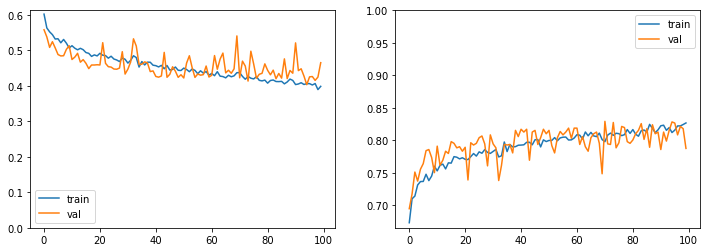

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5795 - accuracy: 0.5317 - precision: 0.9656 - recall: 0.4949 - f1: 0.6481 - specificity: 0.8624 - negative_predictive_value: 0.1794 - matthews_correlation_coefficient: 0.2240 - val_loss: 0.6738 - val_accuracy: 0.4588 - val_precision: 0.9535 - val_recall: 0.3885 - val_f1: 0.5466 - val_specificity: 0.9039 - val_negative_predictive_value: 0.1567 - val_matthews_correlation_coefficient: 0.2071

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.20707, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_27-21_34_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5580 - accuracy: 0.5555 - precision: 0.9676 - recall: 0.5196 - f1: 0.6648 - specificity: 0.8199 - negative_predictive_value: 0.1916 - matthews_correlation_coefficient: 0.2293 - val_loss: 0.5803 - val_accuracy: 0.4918 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4724 - accuracy: 0.6965 - precision: 0.9706 - recall: 0.6845 - f1: 0.7945 - specificity: 0.7903 - negative_predictive_value: 0.2587 - matthews_correlation_coefficient: 0.3285 - val_loss: 0.6123 - val_accuracy: 0.5785 - val_precision: 0.9483 - val_recall: 0.5255 - val_f1: 0.6690 - val_specificity: 0.8791 - val_negative_predictive_value: 0.2147 - val_matthews_correlation_coefficient: 0.2525

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.30967
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4609 - accuracy: 0.7143 - precision: 0.9742 - recall: 0.7027 - f1: 0.8085 - specificity: 0.8332 - negative_predictive_value: 0.2729 - matthews_correlation_coefficient: 0.3552 - val_loss: 0.5426 - val_accuracy: 0.6548 - val_precision: 0.9511 - val_recall: 0.6085 - val_f1: 0.7390 - val_specificity: 0.8946 - val_negative_predictive_value: 0.2507 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4080 - accuracy: 0.7720 - precision: 0.9761 - recall: 0.7666 - f1: 0.8495 - specificity: 0.8158 - negative_predictive_value: 0.3407 - matthews_correlation_coefficient: 0.4169 - val_loss: 0.5295 - val_accuracy: 0.6791 - val_precision: 0.9659 - val_recall: 0.6268 - val_f1: 0.7569 - val_specificity: 0.9458 - val_negative_predictive_value: 0.2701 - val_matthews_correlation_coefficient: 0.3606

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.41030
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3943 - accuracy: 0.7681 - precision: 0.9772 - recall: 0.7570 - f1: 0.8477 - specificity: 0.8369 - negative_predictive_value: 0.3197 - matthews_correlation_coefficient: 0.4119 - val_loss: 0.2601 - val_accuracy: 0.8951 - val_precision: 0.9319 - val_recall: 0.8966 - val_f1: 0.9131 - val_specificity: 0.6879 - val_negative_predictive_value: 0.5330 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3550 - accuracy: 0.7998 - precision: 0.9807 - recall: 0.7894 - f1: 0.8688 - specificity: 0.8395 - negative_predictive_value: 0.3722 - matthews_correlation_coefficient: 0.4620 - val_loss: 0.4248 - val_accuracy: 0.7407 - val_precision: 0.9654 - val_recall: 0.6955 - val_f1: 0.8059 - val_specificity: 0.9299 - val_negative_predictive_value: 0.3119 - val_matthews_correlation_coefficient: 0.4084

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3808 - accuracy: 0.7924 - precision: 0.9823 - recall: 0.7824 - f1: 0.8634 - specificity: 0.8533 - negative_predictive_value: 0.3646 - matthews_correlation_coefficient: 0.4599 - val_loss: 0.4690 - val_accuracy: 0.7320 - val_precision: 0.9660 - val_recall: 0.6852 - val_f1: 0.7984 - val_spe


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3620 - accuracy: 0.7874 - precision: 0.9817 - recall: 0.7787 - f1: 0.8613 - specificity: 0.8381 - negative_predictive_value: 0.3641 - matthews_correlation_coefficient: 0.4541 - val_loss: 0.6491 - val_accuracy: 0.6513 - val_precision: 0.9685 - val_recall: 0.5947 - val_f1: 0.7329 - val_specificity: 0.9518 - val_negative_predictive_value: 0.2572 - val_matthews_correlation_coefficient: 0.3444

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.50887
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3352 - accuracy: 0.8111 - precision: 0.9812 - recall: 0.8014 - f1: 0.8779 - specificity: 0.8647 - negative_predictive_value: 0.3753 - matthews_correlation_coefficient: 0.4784 - val_loss: 0.5923 - val_accuracy: 0.6635 - val_precision: 0.9687 - val_recall: 0.6073 - val_f1: 0.7425 - val_spe

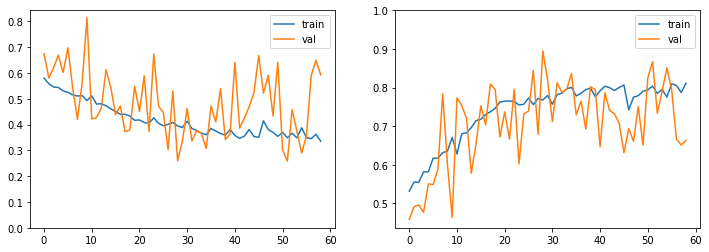

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5788 - accuracy: 0.6499 - precision: 0.9069 - recall: 0.6282 - f1: 0.7335 - specificity: 0.7367 - negative_predictive_value: 0.3445 - matthews_correlation_coefficient: 0.3018 - val_loss: 0.6149 - val_accuracy: 0.6808 - val_precision: 0.9020 - val_recall: 0.6819 - val_f1: 0.7731 - val_specificity: 0.6897 - val_negative_predictive_value: 0.3503 - val_matthews_correlation_coefficient: 0.3049

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30494, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_27-21_43_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5588 - accuracy: 0.6950 - precision: 0.9097 - recall: 0.6834 - f1: 0.7749 - specificity: 0.7243 - negative_predictive_value: 0.3787 - matthews_correlation_coefficient: 0.3417 - val_loss: 0.6080 - val_accuracy: 0.6080 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5234 - accuracy: 0.7143 - precision: 0.9183 - recall: 0.7065 - f1: 0.7916 - specificity: 0.7346 - negative_predictive_value: 0.4018 - matthews_correlation_coefficient: 0.3749 - val_loss: 0.5759 - val_accuracy: 0.6834 - val_precision: 0.9178 - val_recall: 0.6716 - val_f1: 0.7706 - val_specificity: 0.7411 - val_negative_predictive_value: 0.3636 - val_matthews_correlation_coefficient: 0.3394

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36326
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5220 - accuracy: 0.7143 - precision: 0.9152 - recall: 0.7082 - f1: 0.7929 - specificity: 0.7379 - negative_predictive_value: 0.4003 - matthews_correlation_coefficient: 0.3730 - val_loss: 0.5362 - val_accuracy: 0.6843 - val_precision: 0.9196 - val_recall: 0.6701 - val_f1: 0.7709 - val_specificity: 0.7510 - val_negative_predictive_value: 0.3652 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient improved from 0.40181 to 0.40580, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_27-21_43_26.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4885 - accuracy: 0.7384 - precision: 0.9176 - recall: 0.7293 - f1: 0.8064 - specificity: 0.7656 - negative_predictive_value: 0.4382 - matthews_correlation_coefficient: 0.4215 - val_loss: 0.5385 - val_accuracy: 0.7095 - val_precision: 0.9360 - val_recall: 0.6891 - val_f1: 0.7890 - val_specificity: 0.8038 - val_negative_predictive_value: 0.3968 - val_matthews_correlation_coefficient: 0.4032

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.40580
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4898 - accuracy: 0.7219 - precision: 0.9293 - recall: 0.7051 - f1: 0.7950 - specificity: 0.7907 - negative_predictive_value: 0.4194 - matthews_correlation_coefficient: 0.4135 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4737 - accuracy: 0.7343 - precision: 0.9271 - recall: 0.7251 - f1: 0.8058 - specificity: 0.7742 - negative_predictive_value: 0.4329 - matthews_correlation_coefficient: 0.4243 - val_loss: 0.5154 - val_accuracy: 0.7173 - val_precision: 0.9300 - val_recall: 0.7058 - val_f1: 0.7981 - val_specificity: 0.7749 - val_negative_predictive_value: 0.3992 - val_matthews_correlation_coefficient: 0.3962

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.43212
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4724 - accuracy: 0.7347 - precision: 0.9292 - recall: 0.7249 - f1: 0.8085 - specificity: 0.7877 - negative_predictive_value: 0.4324 - matthews_correlation_coefficient: 0.4266 - val_loss: 0.5167 - val_accuracy: 0.7207 - val_precision: 0.9270 - val_recall: 0.7116 - val_f1: 0.8008 - val_specificity: 0.7579 - val_negative_predictive_value: 0.3979 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4645 - accuracy: 0.7501 - precision: 0.9284 - recall: 0.7453 - f1: 0.8193 - specificity: 0.7820 - negative_predictive_value: 0.4511 - matthews_correlation_coefficient: 0.4454 - val_loss: 0.5236 - val_accuracy: 0.7181 - val_precision: 0.9293 - val_recall: 0.7067 - val_f1: 0.7990 - val_specificity: 0.7746 - val_negative_predictive_value: 0.4016 - val_matthews_correlation_coefficient: 0.3973

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.43212
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4612 - accuracy: 0.7557 - precision: 0.9243 - recall: 0.7459 - f1: 0.8208 - specificity: 0.7712 - negative_predictive_value: 0.4473 - matthews_correlation_coefficient: 0.4365 - val_loss: 0.5713 - val_accuracy: 0.6487 - val_precision: 0.9461 - val_recall: 0.5985 - val_f1: 0.7271 - val_specificity: 0.8567 - val_negative_predictive_value: 0.3513 - val_matthews_correlation_coefficie

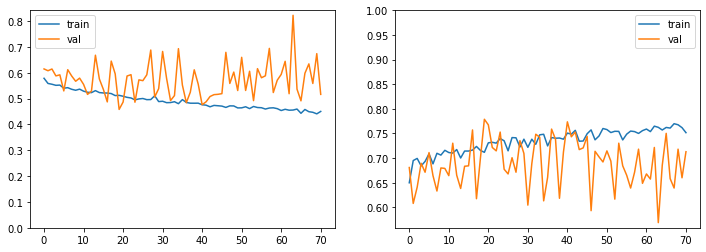

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.7879 - precision: 0.9987 - recall: 0.7900 - f1: 0.8731 - specificity: 0.0621 - negative_predictive_value: 0.0067 - matthews_correlation_coefficient: 0.0169 - val_loss: 0.1556 - val_accuracy: 0.9670 - val_precision: 0.9983 - val_recall: 0.9695 - val_f1: 0.9833 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0367

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03673, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_27-21_54_03.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7336 - precision: 0.9989 - recall: 0.7358 - f1: 0.8349 - specificity: 0.0690 - negative_predictive_value: 0.0091 - matthews_correlation_coefficient: 0.0201 - val_loss: 0.1757 - val_accuracy: 0.9332 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.07972
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1847 - accuracy: 0.8866 - precision: 1.0000 - recall: 0.8870 - f1: 0.9386 - specificity: 0.0897 - negative_predictive_value: 0.0359 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.2155 - val_accuracy: 0.9020 - val_precision: 1.0000 - val_recall: 0.9043 - val_f1: 0.9488 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0414 - val_matthews_correlation_coefficient: 0.0640

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.07972
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1414 - accuracy: 0.9187 - precision: 1.0000 - recall: 0.9189 - f1: 0.9569 - specificity: 0.1034 - negative_predictive_value: 0.0365 - matthews_correlation_coefficient: 0.0571 - val_loss: 0.1910 - val_accuracy: 0.9228 - val_precision: 1.0000 - val_recall: 0.9247 - val_f1: 0.9602 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1507 - accuracy: 0.9156 - precision: 0.9998 - recall: 0.9162 - f1: 0.9550 - specificity: 0.0966 - negative_predictive_value: 0.0451 - matthews_correlation_coefficient: 0.0610 - val_loss: 0.3050 - val_accuracy: 0.8794 - val_precision: 1.0000 - val_recall: 0.8823 - val_f1: 0.9363 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0383 - val_matthews_correlation_coefficient: 0.0605

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1654 - accuracy: 0.9013 - precision: 1.0000 - recall: 0.9017 - f1: 0.9469 - specificity: 0.0966 - negative_predictive_value: 0.0336 - matthews_correlation_coefficient: 0.0542 - val_loss: 0.1913 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.9187 - val_f1: 0.9568 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0428 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1065 - accuracy: 0.9377 - precision: 1.0000 - recall: 0.9380 - f1: 0.9670 - specificity: 0.0966 - negative_predictive_value: 0.0568 - matthews_correlation_coefficient: 0.0708 - val_loss: 0.0289 - val_accuracy: 0.9835 - val_precision: 1.0000 - val_recall: 0.9839 - val_f1: 0.9917 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficient: 0.0999

Epoch 00044: val_matthews_correlation_coefficient improved from 0.09617 to 0.09988, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_27-21_54_03.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1054 - accuracy: 0.9408 - precision: 1.0000 - recall: 0.9410 - f1: 0.9689 - specificity: 0.1034 - negative_predictive_value: 0.0632 - matthews_correlation_coefficient: 0.0761 - val_loss: 0.0632 - val_accuracy: 0.9731 - val_precision: 1.0000 - val_recall: 0.9738 - val_f1: 0.9865 - val


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1003 - accuracy: 0.9367 - precision: 1.0000 - recall: 0.9369 - f1: 0.9668 - specificity: 0.1034 - negative_predictive_value: 0.0562 - matthews_correlation_coefficient: 0.0722 - val_loss: 0.2651 - val_accuracy: 0.9263 - val_precision: 1.0000 - val_recall: 0.9280 - val_f1: 0.9618 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0563 - val_matthews_correlation_coefficient: 0.0738

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1048 - accuracy: 0.9453 - precision: 1.0000 - recall: 0.9455 - f1: 0.9715 - specificity: 0.1034 - negative_predictive_value: 0.0474 - matthews_correlation_coefficient: 0.0674 - val_loss: 0.0980 - val_accuracy: 0.9627 - val_precision: 1.0000 - val_recall: 0.9636 - val_f1: 0.9811 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0435 - accuracy: 0.9738 - precision: 1.0000 - recall: 0.9738 - f1: 0.9865 - specificity: 0.0966 - negative_predictive_value: 0.0615 - matthews_correlation_coefficient: 0.0740 - val_loss: 0.0294 - val_accuracy: 0.9853 - val_precision: 1.0000 - val_recall: 0.9856 - val_f1: 0.9926 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficient: 0.0999
Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 00074: early stopping

   Final Accuracy:  98.35%
  Final Precision: 100.00%
     Final Recall:  98.35%
  Final F-measure:  99.17%
Final Specificity: 100.00%
        Final NPV:  17.39%
        Final MCC:  41.36%
[[   4    0]
 [  19 1130]]
              precision    recall  f1-score   support

           0 

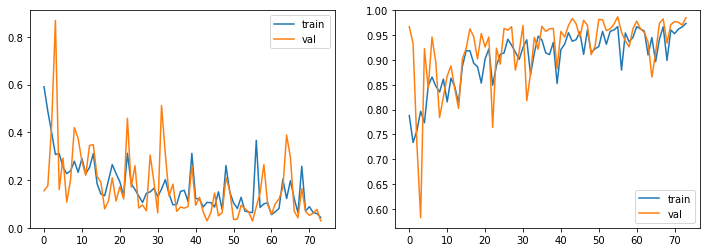

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6005 - accuracy: 0.6161 - precision: 0.8948 - recall: 0.5405 - f1: 0.6584 - specificity: 0.8141 - negative_predictive_value: 0.4088 - matthews_correlation_coefficient: 0.3268 - val_loss: 0.5987 - val_accuracy: 0.6114 - val_precision: 0.8711 - val_recall: 0.5101 - val_f1: 0.6355 - val_specificity: 0.8538 - val_negative_predictive_value: 0.4264 - val_matthews_correlation_coefficient: 0.3272

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.32722, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_27-22_05_07.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5881 - accuracy: 0.6247 - precision: 0.8830 - recall: 0.5546 - f1: 0.6709 - specificity: 0.8146 - negative_predictive_value: 0.4153 - matthews_correlation_coefficient: 0.3317 - val_loss: 0.6507 - val_accuracy: 0.5464 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5406 - accuracy: 0.6881 - precision: 0.9160 - recall: 0.6308 - f1: 0.7399 - specificity: 0.8384 - negative_predictive_value: 0.4673 - matthews_correlation_coefficient: 0.4232 - val_loss: 0.5102 - val_accuracy: 0.6869 - val_precision: 0.8107 - val_recall: 0.6859 - val_f1: 0.7387 - val_specificity: 0.6588 - val_negative_predictive_value: 0.4795 - val_matthews_correlation_coefficient: 0.3149

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39240
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5427 - accuracy: 0.6800 - precision: 0.9071 - recall: 0.6245 - f1: 0.7319 - specificity: 0.8208 - negative_predictive_value: 0.4582 - matthews_correlation_coefficient: 0.4030 - val_loss: 0.5068 - val_accuracy: 0.6938 - val_precision: 0.7784 - val_recall: 0.7443 - val_f1: 0.7563 - val_specificity: 0.5322 - val_negative_predictive_value: 0.4851 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5151 - accuracy: 0.7145 - precision: 0.9133 - recall: 0.6724 - f1: 0.7671 - specificity: 0.8413 - negative_predictive_value: 0.5054 - matthews_correlation_coefficient: 0.4612 - val_loss: 0.5521 - val_accuracy: 0.6912 - val_precision: 0.8850 - val_recall: 0.6162 - val_f1: 0.7206 - val_specificity: 0.8619 - val_negative_predictive_value: 0.4930 - val_matthews_correlation_coefficient: 0.4231

Epoch 00029: val_matthews_correlation_coefficient improved from 0.41966 to 0.42313, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_27-22_05_07.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5090 - accuracy: 0.7078 - precision: 0.9263 - recall: 0.6521 - f1: 0.7587 - specificity: 0.8688 - negative_predictive_value: 0.4941 - matthews_correlation_coefficient: 0.4657 - val_loss: 0.5597 - val_accuracy: 0.6756 - val_precision: 0.8921 - val_recall: 0.5896 - val_f1: 0.7035 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4901 - accuracy: 0.7232 - precision: 0.9237 - recall: 0.6738 - f1: 0.7736 - specificity: 0.8493 - negative_predictive_value: 0.5053 - matthews_correlation_coefficient: 0.4733 - val_loss: 0.5265 - val_accuracy: 0.7086 - val_precision: 0.8869 - val_recall: 0.6385 - val_f1: 0.7372 - val_specificity: 0.8596 - val_negative_predictive_value: 0.5078 - val_matthews_correlation_coefficient: 0.4415

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45708
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4938 - accuracy: 0.7234 - precision: 0.9242 - recall: 0.6750 - f1: 0.7736 - specificity: 0.8543 - negative_predictive_value: 0.5114 - matthews_correlation_coefficient: 0.4782 - val_loss: 0.5683 - val_accuracy: 0.6860 - val_precision: 0.9143 - val_recall: 0.5888 - val_f1: 0.7099 - val_specificity: 0.9134 - val_negative_predictive_value: 0.4871 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4749 - accuracy: 0.7345 - precision: 0.9256 - recall: 0.6863 - f1: 0.7834 - specificity: 0.8516 - negative_predictive_value: 0.5128 - matthews_correlation_coefficient: 0.4856 - val_loss: 0.6238 - val_accuracy: 0.6678 - val_precision: 0.9083 - val_recall: 0.5675 - val_f1: 0.6933 - val_specificity: 0.8989 - val_negative_predictive_value: 0.4676 - val_matthews_correlation_coefficient: 0.4168

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45708
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4802 - accuracy: 0.7328 - precision: 0.9254 - recall: 0.6866 - f1: 0.7823 - specificity: 0.8583 - negative_predictive_value: 0.5175 - matthews_correlation_coefficient: 0.4888 - val_loss: 0.5819 - val_accuracy: 0.6791 - val_precision: 0.9174 - val_recall: 0.5772 - val_f1: 0.7033 - val_specificity: 0.9162 - val_negative_predictive_value: 0.4788 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.46209
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4714 - accuracy: 0.7440 - precision: 0.9169 - recall: 0.6975 - f1: 0.7871 - specificity: 0.8531 - negative_predictive_value: 0.5297 - matthews_correlation_coefficient: 0.4935 - val_loss: 0.6139 - val_accuracy: 0.6592 - val_precision: 0.9250 - val_recall: 0.5431 - val_f1: 0.6779 - val_specificity: 0.9324 - val_negative_predictive_value: 0.4646 - val_matthews_correlation_coefficient: 0.4283

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46209
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4614 - accuracy: 0.7425 - precision: 0.9267 - recall: 0.6975 - f1: 0.7909 - specificity: 0.8459 - negative_predictive_value: 0.5237 - matthews_correlation_coefficient: 0.4944 - val_loss: 0.5651 - val_accuracy: 0.6930 - val_precision: 0.9086 - val_recall: 0.6038 - val_f1: 0.7190 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.46847
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4626 - accuracy: 0.7499 - precision: 0.9276 - recall: 0.7098 - f1: 0.7991 - specificity: 0.8513 - negative_predictive_value: 0.5321 - matthews_correlation_coefficient: 0.5066 - val_loss: 0.4856 - val_accuracy: 0.7320 - val_precision: 0.8833 - val_recall: 0.6797 - val_f1: 0.7634 - val_specificity: 0.8300 - val_negative_predictive_value: 0.5288 - val_matthews_correlation_coefficient: 0.4565

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46847
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4552 - accuracy: 0.7581 - precision: 0.9271 - recall: 0.7214 - f1: 0.8057 - specificity: 0.8461 - negative_predictive_value: 0.5458 - matthews_correlation_coefficient: 0.5177 - val_loss: 0.5656 - val_accuracy: 0.6834 - val_precision: 0.9163 - val_recall: 0.5842 - val_f1: 0.7076 - val_spe

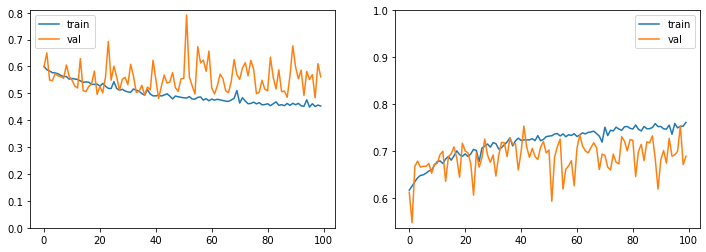

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6021 - accuracy: 0.6137 - precision: 0.9276 - recall: 0.6024 - f1: 0.7112 - specificity: 0.7074 - negative_predictive_value: 0.2318 - matthews_correlation_coefficient: 0.2198 - val_loss: 0.5232 - val_accuracy: 0.7216 - val_precision: 0.8855 - val_recall: 0.7260 - val_f1: 0.7951 - val_specificity: 0.5884 - val_negative_predictive_value: 0.2970 - val_matthews_correlation_coefficient: 0.2357

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23574, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_27-22_19_57.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5491 - accuracy: 0.6488 - precision: 0.9468 - recall: 0.6274 - f1: 0.7466 - specificity: 0.7650 - negative_predictive_value: 0.2645 - matthews_correlation_coefficient: 0.2849 - val_loss: 0.7001 - val_accuracy: 0.5421 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36818
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4758 - accuracy: 0.7323 - precision: 0.9546 - recall: 0.7231 - f1: 0.8185 - specificity: 0.7840 - negative_predictive_value: 0.3307 - matthews_correlation_coefficient: 0.3765 - val_loss: 0.4657 - val_accuracy: 0.7320 - val_precision: 0.9207 - val_recall: 0.7086 - val_f1: 0.7962 - val_specificity: 0.7701 - val_negative_predictive_value: 0.3493 - val_matthews_correlation_coefficient: 0.3517

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36818
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4791 - accuracy: 0.7210 - precision: 0.9435 - recall: 0.7097 - f1: 0.8013 - specificity: 0.7685 - negative_predictive_value: 0.3341 - matthews_correlation_coefficient: 0.3632 - val_loss: 0.4502 - val_accuracy: 0.7511 - val_precision: 0.9080 - val_recall: 0.7433 - val_f1: 0.8136 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4349 - accuracy: 0.7438 - precision: 0.9611 - recall: 0.7349 - f1: 0.8281 - specificity: 0.8009 - negative_predictive_value: 0.3470 - matthews_correlation_coefficient: 0.3990 - val_loss: 0.3836 - val_accuracy: 0.7884 - val_precision: 0.9057 - val_recall: 0.7905 - val_f1: 0.8419 - val_specificity: 0.6803 - val_negative_predictive_value: 0.3928 - val_matthews_correlation_coefficient: 0.3656

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42555
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4252 - accuracy: 0.7568 - precision: 0.9648 - recall: 0.7453 - f1: 0.8356 - specificity: 0.8362 - negative_predictive_value: 0.3744 - matthews_correlation_coefficient: 0.4370 - val_loss: 0.4280 - val_accuracy: 0.7754 - val_precision: 0.9143 - val_recall: 0.7667 - val_f1: 0.8313 - val_specificity: 0.7297 - val_negative_predictive_value: 0.3820 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient improved from 0.42714 to 0.46166, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_27-22_19_57.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3954 - accuracy: 0.7774 - precision: 0.9650 - recall: 0.7700 - f1: 0.8531 - specificity: 0.8252 - negative_predictive_value: 0.3907 - matthews_correlation_coefficient: 0.4551 - val_loss: 0.3304 - val_accuracy: 0.8326 - val_precision: 0.8862 - val_recall: 0.8701 - val_f1: 0.8759 - val_specificity: 0.5143 - val_negative_predictive_value: 0.4333 - val_matthews_correlation_coefficient: 0.3420

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.46166
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4066 - accuracy: 0.7774 - precision: 0.9608 - recall: 0.7712 - f1: 0.8493 - specificity: 0.8145 - negative_predictive_value: 0.3893 - matthews_correlation_coefficient: 0.4475 - val_loss: 0.3999 - val_


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.46166
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4295 - accuracy: 0.7432 - precision: 0.9598 - recall: 0.7352 - f1: 0.8227 - specificity: 0.8126 - negative_predictive_value: 0.3593 - matthews_correlation_coefficient: 0.4094 - val_loss: 0.3334 - val_accuracy: 0.8378 - val_precision: 0.8836 - val_recall: 0.8787 - val_f1: 0.8790 - val_specificity: 0.4906 - val_negative_predictive_value: 0.4623 - val_matthews_correlation_coefficient: 0.3484

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.46166
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3917 - accuracy: 0.7785 - precision: 0.9664 - recall: 0.7702 - f1: 0.8524 - specificity: 0.8200 - negative_predictive_value: 0.3914 - matthews_correlation_coefficient: 0.4522 - val_loss: 0.3442 - val_accuracy: 0.8291 - val_precision: 0.8774 - val_recall: 0.8748 - val_f1: 0.8742 - val_spe


Epoch 00073: val_matthews_correlation_coefficient improved from 0.46166 to 0.47452, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_27-22_19_57.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3623 - accuracy: 0.8078 - precision: 0.9682 - recall: 0.8044 - f1: 0.8744 - specificity: 0.8382 - negative_predictive_value: 0.4403 - matthews_correlation_coefficient: 0.5035 - val_loss: 0.3372 - val_accuracy: 0.8343 - val_precision: 0.8873 - val_recall: 0.8699 - val_f1: 0.8761 - val_specificity: 0.5127 - val_negative_predictive_value: 0.4646 - val_matthews_correlation_coefficient: 0.3573

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.47452
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3626 - accuracy: 0.8063 - precision: 0.9681 - recall: 0.8012 - f1: 0.8741 - specificity: 0.8343 - negative_predictive_value: 0.4197 - matthews_correlation_coefficient: 0.4902 - val_loss: 0.3465 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3969 - accuracy: 0.7944 - precision: 0.9652 - recall: 0.7902 - f1: 0.8632 - specificity: 0.8351 - negative_predictive_value: 0.4236 - matthews_correlation_coefficient: 0.4850 - val_loss: 0.3135 - val_accuracy: 0.8699 - val_precision: 0.8955 - val_recall: 0.9042 - val_f1: 0.8985 - val_specificity: 0.5429 - val_negative_predictive_value: 0.5427 - val_matthews_correlation_coefficient: 0.4315

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.47897
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3704 - accuracy: 0.8197 - precision: 0.9681 - recall: 0.8187 - f1: 0.8832 - specificity: 0.8310 - negative_predictive_value: 0.4640 - matthews_correlation_coefficient: 0.5207 - val_loss: 0.3633 - val_accuracy: 0.8413 - val_precision: 0.9192 - val_recall: 0.8435 - val_f1: 0.8777 - val_specificity: 0.7228 - val_negative_predictive_value: 0.4923 - val_matthews_correlation_coefficie

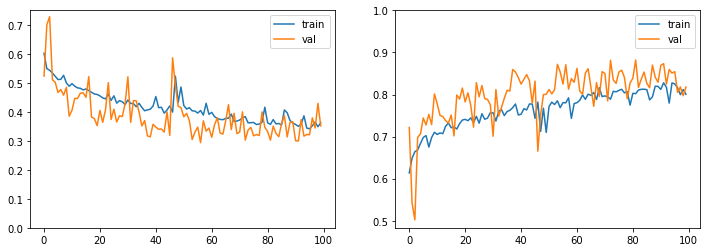

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_27-22_34_54.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_27-22_34_54.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1746 - accuracy: 0.9403 - precision: 0.9942 - recall: 0.9425 - f1: 0.9666 - specificity: 0.7902 - negative_predictive_value: 0.5440 - matthews_correlation_coefficient: 0.6154 - val_loss: 0.1422 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9352 - val_f1: 0.9506 - val_specificity: 0.8063 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.6642

Epoch 00044: val_matthews_correlation_coefficient improved from 0.64469 to 0.66424, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_27-22_34_54.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1627 - accuracy: 0.9538 - precision: 0.9942 - recall: 0.9566 - f1: 0.9745 - specificity: 0.8156 - negative_predictive_value: 0.5999 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.2724

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1434 - accuracy: 0.9544 - precision: 0.9951 - recall: 0.9569 - f1: 0.9749 - specificity: 0.7929 - negative_predictive_value: 0.6069 - matthews_correlation_coefficient: 0.6603 - val_loss: 0.3438 - val_accuracy: 0.8907 - val_precision: 0.9700 - val_recall: 0.8630 - val_f1: 0.9128 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.4800

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1640 - accuracy: 0.9471 - precision: 0.9953 - recall: 0.9483 - f1: 0.9700 - specificity: 0.8495 - negative_predictive_value: 0.5979 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.4156 - val_accuracy: 0.8716 - val_precision: 0.9688 - val_recall: 0.8444 - val_f1: 0.9017 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1380 - accuracy: 0.9555 - precision: 0.9955 - recall: 0.9576 - f1: 0.9757 - specificity: 0.8283 - negative_predictive_value: 0.5924 - matthews_correlation_coefficient: 0.6659 - val_loss: 0.2782 - val_accuracy: 0.8699 - val_precision: 0.9698 - val_recall: 0.8411 - val_f1: 0.9001 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3008 - val_matthews_correlation_coefficient: 0.4507

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1275 - accuracy: 0.9586 - precision: 0.9964 - recall: 0.9596 - f1: 0.9771 - specificity: 0.8432 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.6968 - val_loss: 0.1736 - val_accuracy: 0.9228 - val_precision: 0.9959 - val_recall: 0.9228 - val_f1: 0.9576 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4162 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 00087: early stopping

   Final Accuracy:  98.01%
  Final Precision:  99.35%
     Final Recall:  98.52%
  Final F-measure:  98.93%
Final Specificity:  90.41%
        Final NPV:  80.49%
        Final MCC:  84.26%
[[  66    7]
 [  16 1064]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        73
           1       0.99      0.99      0.99      1080

    accuracy                           0.98      1153
   macro avg       0.90      0.94      0.92      1153
weighted avg       0.98      0.98      0.98      1153



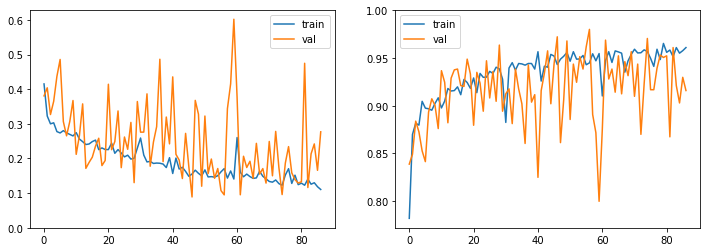

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6055 - accuracy: 0.6336 - precision: 0.8880 - recall: 0.5846 - f1: 0.6954 - specificity: 0.7850 - negative_predictive_value: 0.3925 - matthews_correlation_coefficient: 0.3212 - val_loss: 0.6529 - val_accuracy: 0.6141 - val_precision: 0.8602 - val_recall: 0.5413 - val_f1: 0.6597 - val_specificity: 0.7941 - val_negative_predictive_value: 0.3882 - val_matthews_correlation_coefficient: 0.2868

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28681, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_27-22_47_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5733 - accuracy: 0.6772 - precision: 0.8942 - recall: 0.6490 - f1: 0.7463 - specificity: 0.7637 - negative_predictive_value: 0.4232 - matthews_correlation_coefficient: 0.3614 - val_loss: 0.6244 - val_accuracy: 0.6401 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5290 - accuracy: 0.7078 - precision: 0.9095 - recall: 0.6788 - f1: 0.7717 - specificity: 0.7937 - negative_predictive_value: 0.4546 - matthews_correlation_coefficient: 0.4138 - val_loss: 0.6391 - val_accuracy: 0.6487 - val_precision: 0.8789 - val_recall: 0.5773 - val_f1: 0.6924 - val_specificity: 0.8232 - val_negative_predictive_value: 0.4200 - val_matthews_correlation_coefficient: 0.3440

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36391
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5332 - accuracy: 0.7158 - precision: 0.9009 - recall: 0.6869 - f1: 0.7746 - specificity: 0.7841 - negative_predictive_value: 0.4623 - matthews_correlation_coefficient: 0.4188 - val_loss: 0.5735 - val_accuracy: 0.6843 - val_precision: 0.8753 - val_recall: 0.6371 - val_f1: 0.7312 - val_specificity: 0.7915 - val_negative_predictive_value: 0.4530 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5192 - accuracy: 0.7184 - precision: 0.9140 - recall: 0.6879 - f1: 0.7801 - specificity: 0.8021 - negative_predictive_value: 0.4708 - matthews_correlation_coefficient: 0.4334 - val_loss: 0.5455 - val_accuracy: 0.6973 - val_precision: 0.8690 - val_recall: 0.6601 - val_f1: 0.7455 - val_specificity: 0.7689 - val_negative_predictive_value: 0.4621 - val_matthews_correlation_coefficient: 0.3746

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38603
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5136 - accuracy: 0.7249 - precision: 0.9116 - recall: 0.6992 - f1: 0.7869 - specificity: 0.7908 - negative_predictive_value: 0.4719 - matthews_correlation_coefficient: 0.4330 - val_loss: 0.5250 - val_accuracy: 0.7311 - val_precision: 0.8484 - val_recall: 0.7317 - val_f1: 0.7819 - val_specificity: 0.6823 - val_negative_predictive_value: 0.4935 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4985 - accuracy: 0.7267 - precision: 0.9149 - recall: 0.6975 - f1: 0.7866 - specificity: 0.8004 - negative_predictive_value: 0.4783 - matthews_correlation_coefficient: 0.4416 - val_loss: 0.5179 - val_accuracy: 0.7225 - val_precision: 0.8445 - val_recall: 0.7220 - val_f1: 0.7744 - val_specificity: 0.6840 - val_negative_predictive_value: 0.4849 - val_matthews_correlation_coefficient: 0.3625

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38603
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4979 - accuracy: 0.7289 - precision: 0.9163 - recall: 0.7042 - f1: 0.7917 - specificity: 0.8153 - negative_predictive_value: 0.4857 - matthews_correlation_coefficient: 0.4543 - val_loss: 0.5857 - val_accuracy: 0.6748 - val_precision: 0.8731 - val_recall: 0.6225 - val_f1: 0.7209 - val_specificity: 0.7949 - val_negative_predictive_value: 0.4454 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39560
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4932 - accuracy: 0.7358 - precision: 0.9187 - recall: 0.7125 - f1: 0.7965 - specificity: 0.7971 - negative_predictive_value: 0.4915 - matthews_correlation_coefficient: 0.4571 - val_loss: 0.5404 - val_accuracy: 0.7181 - val_precision: 0.8628 - val_recall: 0.6957 - val_f1: 0.7664 - val_specificity: 0.7431 - val_negative_predictive_value: 0.4838 - val_matthews_correlation_coefficient: 0.3872

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39560
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4914 - accuracy: 0.7325 - precision: 0.9168 - recall: 0.7104 - f1: 0.7950 - specificity: 0.8054 - negative_predictive_value: 0.4849 - matthews_correlation_coefficient: 0.4528 - val_loss: 0.5377 - val_accuracy: 0.7008 - val_precision: 0.8666 - val_recall: 0.6667 - val_f1: 0.7485 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40478
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4759 - accuracy: 0.7416 - precision: 0.9236 - recall: 0.7155 - f1: 0.8010 - specificity: 0.8173 - negative_predictive_value: 0.4951 - matthews_correlation_coefficient: 0.4717 - val_loss: 0.5118 - val_accuracy: 0.7233 - val_precision: 0.8490 - val_recall: 0.7178 - val_f1: 0.7744 - val_specificity: 0.6958 - val_negative_predictive_value: 0.4851 - val_matthews_correlation_coefficient: 0.3690

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40478
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4765 - accuracy: 0.7410 - precision: 0.9194 - recall: 0.7186 - f1: 0.8019 - specificity: 0.8163 - negative_predictive_value: 0.4997 - matthews_correlation_coefficient: 0.4708 - val_loss: 0.5684 - val_accuracy: 0.7034 - val_precision: 0.8648 - val_recall: 0.6739 - val_f1: 0.7520 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.40478
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4911 - accuracy: 0.7280 - precision: 0.9138 - recall: 0.6952 - f1: 0.7824 - specificity: 0.8101 - negative_predictive_value: 0.4885 - matthews_correlation_coefficient: 0.4480 - val_loss: 0.5725 - val_accuracy: 0.6756 - val_precision: 0.8759 - val_recall: 0.6233 - val_f1: 0.7223 - val_specificity: 0.7996 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.3659

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.40478
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4653 - accuracy: 0.7443 - precision: 0.9244 - recall: 0.7196 - f1: 0.8052 - specificity: 0.8217 - negative_predictive_value: 0.5025 - matthews_correlation_coefficient: 0.4793 - val_loss: 0.5301 - val_accuracy: 0.7311 - val_precision: 0.8598 - val_recall: 0.7178 - val_f1: 0.7786 - val_spe

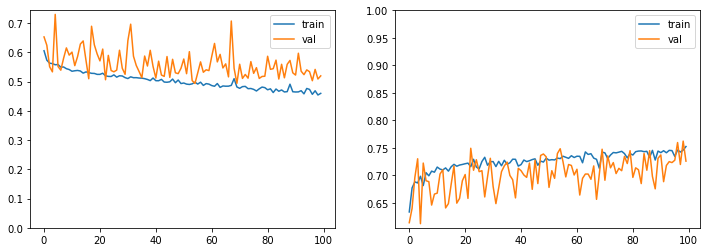

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4471 - accuracy: 0.7714 - precision: 0.9973 - recall: 0.7686 - f1: 0.8574 - specificity: 0.2862 - negative_predictive_value: 0.0579 - matthews_correlation_coefficient: 0.1032 - val_loss: 0.7151 - val_accuracy: 0.6938 - val_precision: 1.0000 - val_recall: 0.6984 - val_f1: 0.8180 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0410 - val_matthews_correlation_coefficient: 0.0897

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.08974, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_27-23_02_46.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3720 - accuracy: 0.8228 - precision: 0.9979 - recall: 0.8234 - f1: 0.9004 - specificity: 0.2747 - negative_predictive_value: 0.0526 - matthews_correlation_coefficient: 0.1026 - val_loss: 0.2559 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2732 - accuracy: 0.8456 - precision: 0.9993 - recall: 0.8455 - f1: 0.9146 - specificity: 0.2966 - negative_predictive_value: 0.0732 - matthews_correlation_coefficient: 0.1329 - val_loss: 0.3477 - val_accuracy: 0.8560 - val_precision: 1.0000 - val_recall: 0.8585 - val_f1: 0.9221 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0933 - val_matthews_correlation_coefficient: 0.1479

Epoch 00015: val_matthews_correlation_coefficient improved from 0.14257 to 0.14790, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_27-23_02_46.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2873 - accuracy: 0.8315 - precision: 0.9988 - recall: 0.8317 - f1: 0.9055 - specificity: 0.3069 - negative_predictive_value: 0.0683 - matthews_correlation_coefficient: 0.1270 - val_loss: 0.2877 - val_accuracy: 0.8465 - val_precision: 1.0000 - val_recall: 0.8489 - val_f


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.14908
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2579 - accuracy: 0.8458 - precision: 0.9995 - recall: 0.8452 - f1: 0.9145 - specificity: 0.3276 - negative_predictive_value: 0.0724 - matthews_correlation_coefficient: 0.1365 - val_loss: 0.3294 - val_accuracy: 0.8040 - val_precision: 1.0000 - val_recall: 0.8069 - val_f1: 0.8908 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0612 - val_matthews_correlation_coefficient: 0.1164

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.14908
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2646 - accuracy: 0.8219 - precision: 0.9994 - recall: 0.8214 - f1: 0.8998 - specificity: 0.3034 - negative_predictive_value: 0.0673 - matthews_correlation_coefficient: 0.1277 - val_loss: 0.2279 - val_accuracy: 0.8638 - val_precision: 0.9990 - val_recall: 0.8670 - val_f1: 0.9269 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.14908 to 0.15415, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_27-23_02_46.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2603 - accuracy: 0.8410 - precision: 0.9993 - recall: 0.8407 - f1: 0.9114 - specificity: 0.3276 - negative_predictive_value: 0.0698 - matthews_correlation_coefficient: 0.1342 - val_loss: 0.2927 - val_accuracy: 0.8413 - val_precision: 0.9979 - val_recall: 0.8456 - val_f1: 0.9138 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0705 - val_matthews_correlation_coefficient: 0.1135

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.15415
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2654 - accuracy: 0.8464 - precision: 0.9995 - recall: 0.8462 - f1: 0.9152 - specificity: 0.3218 - negative_predictive_value: 0.0826 - matthews_correlation_coefficient: 0.1460 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2161 - accuracy: 0.8592 - precision: 0.9998 - recall: 0.8588 - f1: 0.9227 - specificity: 0.3138 - negative_predictive_value: 0.0859 - matthews_correlation_coefficient: 0.1484 - val_loss: 0.2368 - val_accuracy: 0.8812 - val_precision: 1.0000 - val_recall: 0.8833 - val_f1: 0.9370 - val_specificity: 0.2973 - val_negative_predictive_value: 0.1020 - val_matthews_correlation_coefficient: 0.1610

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.18191
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2065 - accuracy: 0.8707 - precision: 0.9995 - recall: 0.8701 - f1: 0.9292 - specificity: 0.3103 - negative_predictive_value: 0.0724 - matthews_correlation_coefficient: 0.1341 - val_loss: 0.3278 - val_accuracy: 0.8612 - val_precision: 1.0000 - val_recall: 0.8637 - val_f1: 0.9255 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0926 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2295 - accuracy: 0.8653 - precision: 0.9993 - recall: 0.8620 - f1: 0.9239 - specificity: 0.2931 - negative_predictive_value: 0.0790 - matthews_correlation_coefficient: 0.1364 - val_loss: 0.3949 - val_accuracy: 0.8057 - val_precision: 1.0000 - val_recall: 0.8087 - val_f1: 0.8921 - val_specificity: 0.2973 - val_negative_predictive_value: 0.0647 - val_matthews_correlation_coefficient: 0.1209

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.18191
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2175 - accuracy: 0.8486 - precision: 0.9998 - recall: 0.8478 - f1: 0.9165 - specificity: 0.3172 - negative_predictive_value: 0.0699 - matthews_correlation_coefficient: 0.1331 - val_loss: 0.2405 - val_accuracy: 0.8846 - val_precision: 1.0000 - val_recall: 0.8868 - val_f1: 0.9390 - val_specificity: 0.2973 - val_negative_predictive_value: 0.1138 - val_matthews_correlation_coefficie

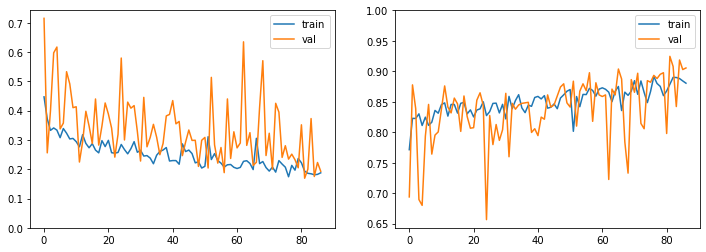

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_27-18_42_05.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_27-18_49_17.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_27-19_02_02.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_27-19_16_37.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_27-19_23_01.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_27-19_37_11.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_27-19_47_11.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_27-19_59_14.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_27-20_13_59.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_27-20_28_39.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_27-20_39_35.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_27-20_54_25.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_27-21_04_53.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.999428]], dtype=float32),
 array([[0.5916039]], dtype=float32),
 array([[0.99916744]], dtype=float32),
 array([[0.9278241]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9966562]], dtype=float32),
 array([[0.9354904]], dtype=float32),
 array([[0.6594622]], dtype=float32),
 array([[0.7341511]], dtype=float32),
 array([[0.7119021]], dtype=float32),
 array([[0.8720084]], dtype=float32),
 array([[0.5726314]], dtype=float32),
 array([[0.99999774]], dtype=float32),
 array([[0.99697304]], dtype=float32),
 array([[0.9500989]], dtype=float32),
 array([[0.2518108]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.807601]], dtype=float32),
 array([[0.9999987]], dtype=float32),
 array([[0.999801]], dtype=float32),
 array([[0.65470606]], dtype=float32),
 array([[1.]], dtype=float32)]